In [17]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Try to import advanced libraries
try:
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    SKLEARN_AVAILABLE = True
    print("Advanced ML libraries loaded successfully")
except ImportError:
    SKLEARN_AVAILABLE = False
    print("Installing scikit-learn for advanced ML...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    SKLEARN_AVAILABLE = True

try:
    from scipy import ndimage, stats
    from scipy.spatial.distance import pdist, squareform
    SCIPY_AVAILABLE = True
    print("SciPy loaded successfully")
except ImportError:
    print("Installing SciPy for advanced features...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    from scipy import ndimage, stats
    from scipy.spatial.distance import pdist, squareform
    SCIPY_AVAILABLE = True

# TensorFlow / Keras imports for deep learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
    from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, InceptionV3
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
    from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
    print("TensorFlow loaded successfully")
except ImportError:
    print("Installing TensorFlow for deep learning...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
    from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, InceptionV3
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
    from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True

def extract_and_setup_dataset():
    """Extract HFD.zip and set up the dataset"""
    print("Looking for HFD.zip...")

    if os.path.exists('HFD.zip'):
        print("Found HFD.zip file")

        with zipfile.ZipFile('HFD.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
            print("Extracted HFD.zip successfully")

        print("\nExploring extracted contents...")
        dataset_path = None

        for root, dirs, files in os.walk('.'):
            for dir_name in dirs:
                if 'human' in dir_name.lower() and 'face' in dir_name.lower():
                    potential_path = os.path.join(root, dir_name)
                    print(f"Found potential dataset folder: {potential_path}")

                    try:
                        subfolders = os.listdir(potential_path)
                        has_ai = any('ai' in folder.lower() or 'generated' in folder.lower() for folder in subfolders)
                        has_real = any('real' in folder.lower() for folder in subfolders)

                        if has_ai and has_real:
                            dataset_path = potential_path
                            print(f"Confirmed dataset path: {dataset_path}")
                            print(f"Subfolders: {subfolders}")
                            break
                    except:
                        continue

            if dataset_path:
                break

        return dataset_path
    else:
        print("HFD.zip not found. Please upload the file first.")
        return None

class AdvancedHumanFaceAnalyzer:
    def __init__(self, dataset_path, img_size=128):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.file_paths = []
        self.features = []
        self.ml_models = {}
        self.dl_models = {}
        self.scaler = StandardScaler()
        self.best_ml_model = None
        self.best_ml_model_name = None
        self.best_ml_accuracy = 0
        self.best_dl_model = None
        self.best_dl_model_name = None
        self.best_dl_accuracy = 0
        self.dl_img_size = img_size  # Will be updated if resized for DL

    def load_images(self, max_images_per_class=1000):
        """Load images with higher limit for better training"""
        print("Loading images...")

        if not os.path.exists(self.dataset_path):
            print(f"Dataset path does not exist: {self.dataset_path}")
            return False

        ai_folder = None
        real_folder = None

        try:
            folders = os.listdir(self.dataset_path)
            print(f"Folders in dataset: {folders}")

            for folder in folders:
                folder_path = os.path.join(self.dataset_path, folder)
                if os.path.isdir(folder_path):
                    folder_lower = folder.lower()
                    if any(term in folder_lower for term in ['ai generated', 'ai_generated', 'ai', 'generated', 'fake', 'synthetic']):
                        ai_folder = folder_path
                        print(f"AI folder: {folder}")
                    elif any(term in folder_lower for term in ['real images', 'real_images', 'real', 'human', 'authentic']):
                        real_folder = folder_path
                        print(f"Real folder: {folder}")
        except Exception as e:
            print(f"Error accessing dataset: {e}")
            return False

        if not ai_folder or not real_folder:
            print("Could not find both AI and Real folders!")
            return False

        print("Loading AI Generated Images...")
        ai_count = self.load_images_from_folder(ai_folder, 'AI_Generated', max_images_per_class)

        print("Loading Real Images...")
        real_count = self.load_images_from_folder(real_folder, 'Real', max_images_per_class)

        print(f"\nDataset loaded:")
        print(f"  AI Generated: {ai_count} images")
        print(f"  Real Images: {real_count} images")
        print(f"  Total: {len(self.images)} images")

        return len(self.images) > 0

    def load_images_from_folder(self, folder_path, label, max_images):
        """Load images from a specific folder"""
        count = 0

        try:
            files = os.listdir(folder_path)
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'))]

            print(f"  Found {len(image_files)} image files in {os.path.basename(folder_path)}")

            for i, filename in enumerate(image_files):
                if count >= max_images:
                    break

                img_path = os.path.join(folder_path, filename)

                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((self.img_size, self.img_size))
                    img_array = np.array(img)

                    self.images.append(img_array)
                    self.labels.append(label)
                    self.file_paths.append(img_path)

                    count += 1

                    if count % 100 == 0:
                        print(f"  Loaded {count} {label} images...")

                except Exception as e:
                    continue

        except Exception as e:
            print(f"Error accessing folder {folder_path}: {e}")

        return count

    def extract_advanced_features(self):
        """Extract comprehensive features for high accuracy"""
        print("Extracting advanced features...")

        self.features = []

        for i, img in enumerate(self.images):
            img_float = img.astype(np.float32)

            # Basic statistical features
            basic_features = [
                np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
                np.median(img_float), np.var(img_float),
                stats.skew(img_float.flatten()), stats.kurtosis(img_float.flatten())
            ]

            # Color channel features
            color_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                color_features.extend([
                    np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                    np.median(ch), np.var(ch),
                    stats.skew(ch.flatten()), stats.kurtosis(ch.flatten())
                ])

            # Gradient features (edge detection)
            gray = np.mean(img_float, axis=2)
            grad_x = np.abs(np.diff(gray, axis=1))
            grad_y = np.abs(np.diff(gray, axis=0))

            min_rows = min(grad_x.shape[0], grad_y.shape[0])
            min_cols = min(grad_x.shape[1], grad_y.shape[1])

            grad_x_trimmed = grad_x[:min_rows, :min_cols]
            grad_y_trimmed = grad_y[:min_rows, :min_cols]

            gradient_features = [
                np.mean(grad_x), np.std(grad_x), np.max(grad_x),
                np.mean(grad_y), np.std(grad_y), np.max(grad_y),
                np.mean(grad_x_trimmed + grad_y_trimmed), np.std(grad_x_trimmed + grad_y_trimmed)
            ]

            # Texture features
            texture_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                diag1 = ch[1:,1:] - ch[:-1,:-1]
                diag2 = ch[1:,:-1] - ch[:-1,1:]

                texture_features.extend([
                    np.mean(np.abs(diag1)),
                    np.mean(np.abs(diag2)),
                    np.std(diag1),
                    np.std(diag2)
                ])

            # Frequency domain features
            freq_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                high_freq = np.abs(ch[2:,2:] - 2*ch[1:-1,1:-1] + ch[:-2,:-2])
                freq_features.extend([
                    np.mean(high_freq), np.std(high_freq), np.max(high_freq)
                ])

            # Brightness and contrast features
            brightness_features = [
                np.mean(gray), np.std(gray),
                np.percentile(gray, 25), np.percentile(gray, 75),
                np.percentile(gray, 90) - np.percentile(gray, 10)
            ]

            # Color distribution features
            color_dist_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                hist, _ = np.histogram(ch, bins=10, range=(0, 255))
                hist = hist / (np.sum(hist) + 1e-8)
                color_dist_features.extend([
                    np.max(hist), np.min(hist), np.std(hist),
                    np.sum(hist[:3]), np.sum(hist[-3:])
                ])

            # Combine all features
            all_features = (basic_features + color_features + gradient_features + 
                          texture_features + freq_features + brightness_features + 
                          color_dist_features)

            self.features.append(all_features)

            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(self.images)} images...")

        self.features = np.array(self.features)
        print(f"Extracted {self.features.shape[1]} advanced features per image")

        return self.features

    def train_machine_learning_models(self):
        """Train multiple ML models and select the best one"""
        print("\n" + "="*60)
        print("TRAINING MACHINE LEARNING MODELS")
        print("="*60)

        if len(self.features) == 0:
            self.extract_advanced_features()

        # Prepare labels
        y = np.array([1 if label == 'AI_Generated' else 0 for label in self.labels])

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Define models to try
        models_to_try = {
            'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=25, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, max_depth=15, random_state=42),
            'SVM (RBF)': SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=True),
            'SVM (Linear)': SVC(kernel='linear', C=1, random_state=42, probability=True),
            'Logistic Regression': LogisticRegression(C=10, random_state=42, max_iter=2000),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance'),
            'Naive Bayes': GaussianNB()
        }

        best_model = None
        best_score = 0
        best_name = ""

        print(f"\nTesting {len(models_to_try)} different ML models:")

        for name, model in models_to_try.items():
            print(f"\n--- Training {name} ---")

            # Train model
            if 'SVM' in name or name == 'Logistic Regression' or name == 'K-Nearest Neighbors':
                model.fit(X_train_scaled, y_train)
                train_score = model.score(X_train_scaled, y_train)
                test_score = model.score(X_test_scaled, y_test)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                train_score = model.score(X_train, y_train)
                test_score = model.score(X_test, y_test)
                y_pred = model.predict(X_test)

            print(f"Training Accuracy: {train_score:.4f} ({train_score*100:.2f}%)")
            print(f"Testing Accuracy: {test_score:.4f} ({test_score*100:.2f}%)")

            # Store model
            self.ml_models[name] = {
                'model': model,
                'train_score': train_score,
                'test_score': test_score,
                'use_scaling': name in ['SVM (RBF)', 'SVM (Linear)', 'Logistic Regression', 'K-Nearest Neighbors'],
                'predictions': y_pred
            }

            if test_score > best_score:
                best_score = test_score
                best_model = model
                best_name = name

        print(f"\n{'='*50}")
        print(f"BEST ML MODEL: {best_name}")
        print(f"BEST TEST ACCURACY: {best_score:.4f} ({best_score*100:.2f}%)")
        print(f"{'='*50}")

        # Detailed evaluation of best model
        best_pred = self.ml_models[best_name]['predictions']
        print(f"\nDetailed Results for {best_name}:")
        print("Classification Report:")
        target_names = ['Real', 'AI Generated']
        print(classification_report(y_test, best_pred, target_names=target_names))

        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, best_pred)
        print(f"Real correctly classified: {cm[0,0]}/{cm[0,0]+cm[0,1]} ({cm[0,0]/(cm[0,0]+cm[0,1])*100:.1f}%)")
        print(f"AI correctly classified: {cm[1,1]}/{cm[1,0]+cm[1,1]} ({cm[1,1]/(cm[1,0]+cm[1,1])*100:.1f}%)")

        self.best_ml_model = best_model
        self.best_ml_model_name = best_name
        self.best_ml_accuracy = best_score

        return best_score

    def prepare_dl_data(self, test_size=0.2, max_dl_images=500):
        """Prepare data for deep learning models with memory optimization"""
        print("Preparing data for deep learning models...")

        # Use only a subset of images for DL to reduce memory usage
        if len(self.images) > max_dl_images:
            print(f"Using only {max_dl_images} images for deep learning to reduce memory usage.")
            indices = np.random.choice(len(self.images), max_dl_images, replace=False)
            selected_images = [self.images[i] for i in indices]
            selected_labels = [self.labels[i] for i in indices]
        else:
            selected_images = self.images
            selected_labels = self.labels

        # Resize images to smaller size for DL if img_size > 64
        if self.img_size > 64:
            print("Resizing images to 64x64 for deep learning to reduce memory usage.")
            resized_images = []
            for img in selected_images:
                pil_img = Image.fromarray(img)
                pil_img = pil_img.resize((64, 64))
                resized_images.append(np.array(pil_img))
            X = np.array(resized_images).astype('float32') / 255.0
            dl_img_size = 64
        else:
            X = np.array(selected_images).astype('float32') / 255.0
            dl_img_size = self.img_size

        y = np.array([1 if label == 'AI_Generated' else 0 for label in selected_labels])
        y_cat = to_categorical(y, num_classes=2)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_cat, test_size=test_size, random_state=42, stratify=y
        )

        # Update img_size for DL models to resized size
        self.dl_img_size = dl_img_size

        return X_train, X_test, y_train, y_test

    def build_simple_cnn(self):
        """Build a simple CNN model"""
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            MaxPooling2D(2,2),
            BatchNormalization(),

            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),

            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),

            Conv2D(256, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),

            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_advanced_cnn(self):
        """Build an advanced CNN model"""
        model = Sequential([
            Conv2D(64, (3,3), activation='relu', input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),
            Dropout(0.25),

            Conv2D(128, (3,3), activation='relu'),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),
            Dropout(0.25),

            Conv2D(256, (3,3), activation='relu'),
            Conv2D(256, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),
            Dropout(0.25),

            Conv2D(512, (3,3), activation='relu'),
            Conv2D(512, (3,3), activation='relu'),
            GlobalAveragePooling2D(),
            
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(512, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_resnet50(self):
        """Build ResNet50 transfer learning model"""
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(resnet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_mobilenetv2(self):
        """Build MobileNetV2 transfer learning model"""
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(mobilenet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_vgg16(self):
        """Build VGG16 transfer learning model"""
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(vgg_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def train_dl_model(self, model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        """Train deep learning model with callbacks"""
        early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        
        print(f"Training with {len(X_train)} samples, validating with {len(X_val)} samples")
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        return history

    def evaluate_dl_model(self, model, X_test, y_test):
        """Evaluate deep learning model"""
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        return acc

    def train_deep_learning_models(self, max_dl_images=500):
        """Train all deep learning models"""
        if not TF_AVAILABLE:
            print("TensorFlow not available, skipping deep learning models.")
            return 0

        print("\n" + "="*60)
        print("TRAINING DEEP LEARNING MODELS")
        print("="*60)

        X_train, X_test, y_train, y_test = self.prepare_dl_data(max_dl_images=max_dl_images)
        print(f"Training data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")

        dl_models_config = {
            'Simple CNN': self.build_simple_cnn,
            'Advanced CNN': self.build_advanced_cnn,
            'ResNet50 Transfer Learning': self.build_resnet50,
            'MobileNetV2 Transfer Learning': self.build_mobilenetv2,
            'VGG16 Transfer Learning': self.build_vgg16
        }

        best_acc = 0
        best_model_name = None
        best_model = None

        for name, model_builder in dl_models_config.items():
            print(f"\n--- Training {name} ---")
            
            try:
                model = model_builder()
                print(f"Model architecture: {model.count_params()} parameters")
                
                # Train the model
                history = self.train_dl_model(model, X_train, y_train, X_test, y_test, epochs=20)
                
                # Evaluate the model
                acc = self.evaluate_dl_model(model, X_test, y_test)
                print(f"Final Test Accuracy: {acc*100:.2f}%")
                
                # Store model info
                self.dl_models[name] = {
                    'model': model,
                    'accuracy': acc,
                    'history': history
                }

                if acc > best_acc:
                    best_acc = acc
                    best_model_name = name
                    best_model = model
                    
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue

        if best_model_name:
            print(f"\n{'='*50}")
            print(f"BEST DL MODEL: {best_model_name}")
            print(f"BEST TEST ACCURACY: {best_acc*100:.2f}%")
            print(f"{'='*50}")

            self.best_dl_model = best_model
            self.best_dl_model_name = best_model_name
            self.best_dl_accuracy = best_acc

        return best_acc

    def display_results_summary(self):
        """Display comprehensive results summary"""
        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS RESULTS")
        print("="*80)
        
        print("\nMACHINE LEARNING MODELS RESULTS:")
        print("-" * 40)
        for name, info in self.ml_models.items():
            print(f"{name:25}: {info['test_score']*100:.2f}%")
        
        if self.best_ml_model_name:
            print(f"\nBest ML Model: {self.best_ml_model_name} ({self.best_ml_accuracy*100:.2f}%)")
        
        if TF_AVAILABLE and self.dl_models:
            print("\nDEEP LEARNING MODELS RESULTS:")
            print("-" * 40)
            for name, info in self.dl_models.items():
                print(f"{name:25}: {info['accuracy']*100:.2f}%")
            
            if self.best_dl_model_name:
                print(f"\nBest DL Model: {self.best_dl_model_name} ({self.best_dl_accuracy*100:.2f}%)")
        
        # Overall best
        overall_best_acc = max(self.best_ml_accuracy, self.best_dl_accuracy)
        if self.best_ml_accuracy > self.best_dl_accuracy:
            overall_best_name = f"{self.best_ml_model_name} (ML)"
        else:
            overall_best_name = f"{self.best_dl_model_name} (DL)"
        
        print("\n" + "="*50)
        print(f"OVERALL BEST MODEL: {overall_best_name}")
        print(f"OVERALL BEST ACCURACY: {overall_best_acc*100:.2f}%")
        print("="*50)
        
        if overall_best_acc >= 0.90:
            print("🎉 SUCCESS: Achieved 90%+ accuracy target!")
        else:
            print(f"📈 Close! Need {(0.90 - overall_best_acc)*100:.1f}% more to reach 90%")

    def run_complete_analysis(self, max_images_per_class=1000, max_dl_images=500):
        """Run complete analysis with both ML and DL models"""
        print("STARTING COMPREHENSIVE HUMAN FACES ANALYSIS: AI vs REAL IMAGES")
        print("="*80)

        if not self.load_images(max_images_per_class=max_images_per_class):
            print("Failed to load images")
            return False

        # Step 2: Extract features for ML models
        print("\nExtracting features for machine learning models...")
        self.extract_advanced_features()

        # Step 3: Train ML models
        best_ml_acc = self.train_machine_learning_models()

        # Step 4: Train DL models
        best_dl_acc = 0
        if TF_AVAILABLE:
            best_dl_acc = self.train_deep_learning_models(max_dl_images=max_dl_images)

        # Step 5: Display comprehensive results
        self.display_results_summary()

        return True

    def predict_single_image(self, image_path, use_best_model=True):
        """Predict if a single image is AI-generated or real"""
        try:
            # Load and preprocess image
            img = Image.open(image_path).convert('RGB')
            img = img.resize((self.img_size, self.img_size))
            img_array = np.array(img)

            if use_best_model and self.best_ml_accuracy > self.best_dl_accuracy:
                # Use best ML model
                features = self.extract_single_image_features(img_array)
                features = features.reshape(1, -1)
                
                if self.ml_models[self.best_ml_model_name]['use_scaling']:
                    features = self.scaler.transform(features)
                
                prediction = self.best_ml_model.predict(features)[0]
                confidence = self.best_ml_model.predict_proba(features)[0]
                
                result = "AI Generated" if prediction == 1 else "Real"
                conf_score = confidence[prediction] * 100
                
            elif use_best_model and self.best_dl_model is not None:
                # Use best DL model
                img_normalized = np.array([img_array.astype('float32') / 255.0])
                prediction = self.best_dl_model.predict(img_normalized, verbose=0)[0]
                
                ai_prob = prediction[1]
                real_prob = prediction[0]
                
                if ai_prob > real_prob:
                    result = "AI Generated"
                    conf_score = ai_prob * 100
                else:
                    result = "Real"
                    conf_score = real_prob * 100
            
            else:
                return "No trained model available"
            
            return f"Prediction: {result} (Confidence: {conf_score:.1f}%)"
            
        except Exception as e:
            return f"Error processing image: {str(e)}"

    def extract_single_image_features(self, img_array):
        """Extract features from a single image for ML prediction"""
        img_float = img_array.astype(np.float32)

        # Basic statistical features
        basic_features = [
            np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
            np.median(img_float), np.var(img_float),
            stats.skew(img_float.flatten()), stats.kurtosis(img_float.flatten())
        ]

        # Color channel features
        color_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            color_features.extend([
                np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                np.median(ch), np.var(ch),
                stats.skew(ch.flatten()), stats.kurtosis(ch.flatten())
            ])

        # Gradient features
        gray = np.mean(img_float, axis=2)
        grad_x = np.abs(np.diff(gray, axis=1))
        grad_y = np.abs(np.diff(gray, axis=0))

        min_rows = min(grad_x.shape[0], grad_y.shape[0])
        min_cols = min(grad_x.shape[1], grad_y.shape[1])

        grad_x_trimmed = grad_x[:min_rows, :min_cols]
        grad_y_trimmed = grad_y[:min_rows, :min_cols]

        gradient_features = [
            np.mean(grad_x), np.std(grad_x), np.max(grad_x),
            np.mean(grad_y), np.std(grad_y), np.max(grad_y),
            np.mean(grad_x_trimmed + grad_y_trimmed), np.std(grad_x_trimmed + grad_y_trimmed)
        ]

        # Texture features
        texture_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            diag1 = ch[1:,1:] - ch[:-1,:-1]
            diag2 = ch[1:,:-1] - ch[:-1,1:]

            texture_features.extend([
                np.mean(np.abs(diag1)),
                np.mean(np.abs(diag2)),
                np.std(diag1),
                np.std(diag2)
            ])

        # Frequency domain features
        freq_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            high_freq = np.abs(ch[2:,2:] - 2*ch[1:-1,1:-1] + ch[:-2,:-2])
            freq_features.extend([
                np.mean(high_freq), np.std(high_freq), np.max(high_freq)
            ])

        # Brightness and contrast features
        brightness_features = [
            np.mean(gray), np.std(gray),
            np.percentile(gray, 25), np.percentile(gray, 75),
            np.percentile(gray, 90) - np.percentile(gray, 10)
        ]

        # Color distribution features
        color_dist_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            hist, _ = np.histogram(ch, bins=10, range=(0, 255))
            hist = hist / (np.sum(hist) + 1e-8)
            color_dist_features.extend([
                np.max(hist), np.min(hist), np.std(hist),
                np.sum(hist[:3]), np.sum(hist[-3:])
            ])

        # Combine all features
        all_features = (basic_features + color_features + gradient_features + 
                      texture_features + freq_features + brightness_features + 
                      color_dist_features)

        return np.array(all_features)

    def save_models(self, save_path="saved_models"):
        """Save trained models"""
        import joblib
        import os
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        # Save ML models
        if self.best_ml_model is not None:
            joblib.dump(self.best_ml_model, f"{save_path}/best_ml_model.pkl")
            joblib.dump(self.scaler, f"{save_path}/scaler.pkl")
            print(f"Saved best ML model: {self.best_ml_model_name}")
        
        # Save DL models
        if self.best_dl_model is not None:
            self.best_dl_model.save(f"{save_path}/best_dl_model.h5")
            print(f"Saved best DL model: {self.best_dl_model_name}")
        
        print(f"Models saved to {save_path}/")

def main():
    """Main function to run the complete analysis"""
    print("🚀 ADVANCED HUMAN FACE DETECTOR: AI vs REAL")
    print("="*60)
    
    # Step 1: Extract and setup dataset
    dataset_path = extract_and_setup_dataset()
    if not dataset_path:
        print("❌ Could not setup dataset. Please ensure HFD.zip is in the current directory.")
        return
    
    # Step 2: Initialize analyzer
    analyzer = AdvancedHumanFaceAnalyzer(dataset_path)
    
    # Step 3: Run complete analysis
    print(f"📊 Starting analysis with dataset: {dataset_path}")
    success = analyzer.run_complete_analysis(max_images_per_class=2500, max_dl_images=5000)
    
    if success:
        print("\n✅ Analysis completed successfully!")
        
        # Optional: Save models
        try:
            analyzer.save_models()
            print("💾 Models saved successfully!")
        except Exception as e:
            print(f"⚠️ Could not save models: {e}")
        
        # Example of single image prediction (if you have a test image)
        # print("\n🔍 Example single image prediction:")
        # result = analyzer.predict_single_image("path_to_test_image.jpg")
        # print(result)
        
    else:
        print("❌ Analysis failed!")

# Additional utility functions
def quick_test_single_image(model_path, image_path):
    """Quick function to test a single image with saved model"""
    import joblib
    from PIL import Image
    import numpy as np
    
    try:
        # Load saved model and scaler
        model = joblib.load(f"{model_path}/best_ml_model.pkl")
        scaler = joblib.load(f"{model_path}/scaler.pkl")
        
        # Load and process image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.array(img)
        
        # Extract features (simplified version)
        img_float = img_array.astype(np.float32)
        features = [
            np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
            np.median(img_float), np.var(img_float)
        ]
        
        features = np.array(features).reshape(1, -1)
        features_scaled = scaler.transform(features)
        
        prediction = model.predict(features_scaled)[0]
        confidence = model.predict_proba(features_scaled)[0]
        
        result = "AI Generated" if prediction == 1 else "Real"
        conf_score = confidence[prediction] * 100
        
        return f"Prediction: {result} (Confidence: {conf_score:.1f}%)"
        
    except Exception as e:
        return f"Error: {str(e)}"

def compare_models_performance():
    """Function to compare all model performances"""
    print("📈 MODEL PERFORMANCE COMPARISON")
    print("="*50)
    print("This function would show:")
    print("- Accuracy comparison charts")
    print("- Training time comparison")
    print("- Memory usage analysis")
    print("- Confusion matrices for each model")
    print("- ROC curves")

if __name__ == "__main__":
    main()

Advanced ML libraries loaded successfully
SciPy loaded successfully
TensorFlow loaded successfully
🚀 ADVANCED HUMAN FACE DETECTOR: AI vs REAL
Looking for HFD.zip...
Found HFD.zip file
Extracted HFD.zip successfully

Exploring extracted contents...
Found potential dataset folder: .\Human Faces Dataset
Confirmed dataset path: .\Human Faces Dataset
Subfolders: ['AI-Generated Images', 'Real Images']
📊 Starting analysis with dataset: .\Human Faces Dataset
STARTING COMPREHENSIVE HUMAN FACES ANALYSIS: AI vs REAL IMAGES
Loading images...
Folders in dataset: ['AI-Generated Images', 'Real Images']
AI folder: AI-Generated Images
Real folder: Real Images
Loading AI Generated Images...
  Found 4630 image files in AI-Generated Images
  Loaded 100 AI_Generated images...
  Loaded 200 AI_Generated images...
  Loaded 300 AI_Generated images...
  Loaded 400 AI_Generated images...
  Loaded 500 AI_Generated images...
  Loaded 600 AI_Generated images...
  Loaded 700 AI_Generated images...
  Loaded 800 AI_Ge

Final Test Accuracy: 50.00%

BEST DL MODEL: Simple CNN
BEST TEST ACCURACY: 100.00%

COMPREHENSIVE ANALYSIS RESULTS

MACHINE LEARNING MODELS RESULTS:
----------------------------------------
Random Forest            : 98.30%
Gradient Boosting        : 96.90%
SVM (RBF)                : 99.10%
SVM (Linear)             : 97.90%
Logistic Regression      : 97.90%
K-Nearest Neighbors      : 93.80%
Naive Bayes              : 89.50%

Best ML Model: SVM (RBF) (99.10%)

DEEP LEARNING MODELS RESULTS:
----------------------------------------
Simple CNN               : 100.00%
ResNet50 Transfer Learning: 98.40%
MobileNetV2 Transfer Learning: 95.00%
VGG16 Transfer Learning  : 50.00%

Best DL Model: Simple CNN (100.00%)

OVERALL BEST MODEL: Simple CNN (DL)
OVERALL BEST ACCURACY: 100.00%
🎉 SUCCESS: Achieved 90%+ accuracy target!

✅ Analysis completed successfully!
Saved best ML model: SVM (RBF)
Saved best DL model: Simple CNN
Models saved to saved_models/
💾 Models saved successfully!


In [1]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Try to import advanced libraries
try:
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    SKLEARN_AVAILABLE = True
    print("Advanced ML libraries loaded successfully")
except ImportError:
    SKLEARN_AVAILABLE = False
    print("Installing scikit-learn for advanced ML...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    SKLEARN_AVAILABLE = True

try:
    from scipy import ndimage, stats
    from scipy.spatial.distance import pdist, squareform
    SCIPY_AVAILABLE = True
    print("SciPy loaded successfully")
except ImportError:
    print("Installing SciPy for advanced features...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    from scipy import ndimage, stats
    from scipy.spatial.distance import pdist, squareform
    SCIPY_AVAILABLE = True

# TensorFlow / Keras imports for deep learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
    from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, InceptionV3, DenseNet121
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
    from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
    from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
    print("TensorFlow loaded successfully")
except ImportError:
    print("Installing TensorFlow for deep learning...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
    from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, InceptionV3, DenseNet121
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
    from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
    from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True

def extract_and_setup_dataset():
    """Extract HFD.zip and set up the dataset"""
    print("Looking for HFD.zip...")

    if os.path.exists('HFD.zip'):
        print("Found HFD.zip file")

        with zipfile.ZipFile('HFD.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
            print("Extracted HFD.zip successfully")

        print("\nExploring extracted contents...")
        dataset_path = None

        for root, dirs, files in os.walk('.'):
            for dir_name in dirs:
                if 'human' in dir_name.lower() and 'face' in dir_name.lower():
                    potential_path = os.path.join(root, dir_name)
                    print(f"Found potential dataset folder: {potential_path}")

                    try:
                        subfolders = os.listdir(potential_path)
                        has_ai = any('ai' in folder.lower() or 'generated' in folder.lower() for folder in subfolders)
                        has_real = any('real' in folder.lower() for folder in subfolders)

                        if has_ai and has_real:
                            dataset_path = potential_path
                            print(f"Confirmed dataset path: {dataset_path}")
                            print(f"Subfolders: {subfolders}")
                            break
                    except:
                        continue

            if dataset_path:
                break

        return dataset_path
    else:
        print("HFD.zip not found. Please upload the file first.")
        return None

class AdvancedHumanFaceAnalyzer:
    def __init__(self, dataset_path, img_size=128):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.file_paths = []
        self.features = []
        self.ml_models = {}
        self.dl_models = {}
        self.scaler = StandardScaler()
        self.best_ml_model = None
        self.best_ml_model_name = None
        self.best_ml_accuracy = 0
        self.best_dl_model = None
        self.best_dl_model_name = None
        self.best_dl_accuracy = 0
        self.dl_img_size = img_size  # Will be updated if resized for DL

    def load_images(self, max_images_per_class=1000):
        """Load images with higher limit for better training"""
        print("Loading images...")

        if not os.path.exists(self.dataset_path):
            print(f"Dataset path does not exist: {self.dataset_path}")
            return False

        ai_folder = None
        real_folder = None

        try:
            folders = os.listdir(self.dataset_path)
            print(f"Folders in dataset: {folders}")

            for folder in folders:
                folder_path = os.path.join(self.dataset_path, folder)
                if os.path.isdir(folder_path):
                    folder_lower = folder.lower()
                    if any(term in folder_lower for term in ['ai generated', 'ai_generated', 'ai', 'generated', 'fake', 'synthetic']):
                        ai_folder = folder_path
                        print(f"AI folder: {folder}")
                    elif any(term in folder_lower for term in ['real images', 'real_images', 'real', 'human', 'authentic']):
                        real_folder = folder_path
                        print(f"Real folder: {folder}")
        except Exception as e:
            print(f"Error accessing dataset: {e}")
            return False

        if not ai_folder or not real_folder:
            print("Could not find both AI and Real folders!")
            return False

        print("Loading AI Generated Images...")
        ai_count = self.load_images_from_folder(ai_folder, 'AI_Generated', max_images_per_class)

        print("Loading Real Images...")
        real_count = self.load_images_from_folder(real_folder, 'Real', max_images_per_class)

        print(f"\nDataset loaded:")
        print(f"  AI Generated: {ai_count} images")
        print(f"  Real Images: {real_count} images")
        print(f"  Total: {len(self.images)} images")

        return len(self.images) > 0

    def load_images_from_folder(self, folder_path, label, max_images):
        """Load images from a specific folder"""
        count = 0

        try:
            files = os.listdir(folder_path)
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'))]

            print(f"  Found {len(image_files)} image files in {os.path.basename(folder_path)}")

            for i, filename in enumerate(image_files):
                if count >= max_images:
                    break

                img_path = os.path.join(folder_path, filename)

                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((self.img_size, self.img_size))
                    img_array = np.array(img)

                    self.images.append(img_array)
                    self.labels.append(label)
                    self.file_paths.append(img_path)

                    count += 1

                    if count % 100 == 0:
                        print(f"  Loaded {count} {label} images...")

                except Exception as e:
                    continue

        except Exception as e:
            print(f"Error accessing folder {folder_path}: {e}")

        return count

    def extract_advanced_features(self):
        """Extract comprehensive features for high accuracy"""
        print("Extracting advanced features...")

        self.features = []

        for i, img in enumerate(self.images):
            img_float = img.astype(np.float32)

            # Basic statistical features
            basic_features = [
                np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
                np.median(img_float), np.var(img_float),
                stats.skew(img_float.flatten()), stats.kurtosis(img_float.flatten())
            ]

            # Color channel features
            color_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                color_features.extend([
                    np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                    np.median(ch), np.var(ch),
                    stats.skew(ch.flatten()), stats.kurtosis(ch.flatten())
                ])

            # Gradient features (edge detection)
            gray = np.mean(img_float, axis=2)
            grad_x = np.abs(np.diff(gray, axis=1))
            grad_y = np.abs(np.diff(gray, axis=0))

            min_rows = min(grad_x.shape[0], grad_y.shape[0])
            min_cols = min(grad_x.shape[1], grad_y.shape[1])

            grad_x_trimmed = grad_x[:min_rows, :min_cols]
            grad_y_trimmed = grad_y[:min_rows, :min_cols]

            gradient_features = [
                np.mean(grad_x), np.std(grad_x), np.max(grad_x),
                np.mean(grad_y), np.std(grad_y), np.max(grad_y),
                np.mean(grad_x_trimmed + grad_y_trimmed), np.std(grad_x_trimmed + grad_y_trimmed)
            ]

            # Texture features
            texture_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                diag1 = ch[1:,1:] - ch[:-1,:-1]
                diag2 = ch[1:,:-1] - ch[:-1,1:]

                texture_features.extend([
                    np.mean(np.abs(diag1)),
                    np.mean(np.abs(diag2)),
                    np.std(diag1),
                    np.std(diag2)
                ])

            # Frequency domain features
            freq_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                high_freq = np.abs(ch[2:,2:] - 2*ch[1:-1,1:-1] + ch[:-2,:-2])
                freq_features.extend([
                    np.mean(high_freq), np.std(high_freq), np.max(high_freq)
                ])

            # Brightness and contrast features
            brightness_features = [
                np.mean(gray), np.std(gray),
                np.percentile(gray, 25), np.percentile(gray, 75),
                np.percentile(gray, 90) - np.percentile(gray, 10)
            ]

            # Color distribution features
            color_dist_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                hist, _ = np.histogram(ch, bins=10, range=(0, 255))
                hist = hist / (np.sum(hist) + 1e-8)
                color_dist_features.extend([
                    np.max(hist), np.min(hist), np.std(hist),
                    np.sum(hist[:3]), np.sum(hist[-3:])
                ])

            # Combine all features
            all_features = (basic_features + color_features + gradient_features + 
                          texture_features + freq_features + brightness_features + 
                          color_dist_features)

            self.features.append(all_features)

            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(self.images)} images...")

        self.features = np.array(self.features)
        print(f"Extracted {self.features.shape[1]} advanced features per image")

        return self.features

    def train_machine_learning_models(self):
        """Train multiple ML models and select the best one"""
        print("\n" + "="*60)
        print("TRAINING MACHINE LEARNING MODELS")
        print("="*60)

        if len(self.features) == 0:
            self.extract_advanced_features()

        # Prepare labels
        y = np.array([1 if label == 'AI_Generated' else 0 for label in self.labels])

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Define models to try
        models_to_try = {
            'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=25, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, max_depth=15, random_state=42),
            'SVM (RBF)': SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=True),
            'SVM (Linear)': SVC(kernel='linear', C=1, random_state=42, probability=True),
            'Logistic Regression': LogisticRegression(C=10, random_state=42, max_iter=2000),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance'),
            'Naive Bayes': GaussianNB()
        }

        best_model = None
        best_score = 0
        best_name = ""

        print(f"\nTesting {len(models_to_try)} different ML models:")

        for name, model in models_to_try.items():
            print(f"\n--- Training {name} ---")

            # Train model
            if 'SVM' in name or name == 'Logistic Regression' or name == 'K-Nearest Neighbors':
                model.fit(X_train_scaled, y_train)
                train_score = model.score(X_train_scaled, y_train)
                test_score = model.score(X_test_scaled, y_test)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                train_score = model.score(X_train, y_train)
                test_score = model.score(X_test, y_test)
                y_pred = model.predict(X_test)

            print(f"Training Accuracy: {train_score:.4f} ({train_score*100:.2f}%)")
            print(f"Testing Accuracy: {test_score:.4f} ({test_score*100:.2f}%)")

            # Store model
            self.ml_models[name] = {
                'model': model,
                'train_score': train_score,
                'test_score': test_score,
                'use_scaling': name in ['SVM (RBF)', 'SVM (Linear)', 'Logistic Regression', 'K-Nearest Neighbors'],
                'predictions': y_pred
            }

            if test_score > best_score:
                best_score = test_score
                best_model = model
                best_name = name

        print(f"\n{'='*50}")
        print(f"BEST ML MODEL: {best_name}")
        print(f"BEST TEST ACCURACY: {best_score:.4f} ({best_score*100:.2f}%)")
        print(f"{'='*50}")

        # Detailed evaluation of best model
        best_pred = self.ml_models[best_name]['predictions']
        print(f"\nDetailed Results for {best_name}:")
        print("Classification Report:")
        target_names = ['Real', 'AI Generated']
        print(classification_report(y_test, best_pred, target_names=target_names))

        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, best_pred)
        print(f"Real correctly classified: {cm[0,0]}/{cm[0,0]+cm[0,1]} ({cm[0,0]/(cm[0,0]+cm[0,1])*100:.1f}%)")
        print(f"AI correctly classified: {cm[1,1]}/{cm[1,0]+cm[1,1]} ({cm[1,1]/(cm[1,0]+cm[1,1])*100:.1f}%)")

        self.best_ml_model = best_model
        self.best_ml_model_name = best_name
        self.best_ml_accuracy = best_score

        return best_score

    def prepare_dl_data(self, test_size=0.2, max_dl_images=500):
        """Prepare data for deep learning models with memory optimization"""
        print("Preparing data for deep learning models...")

        # Use only a subset of images for DL to reduce memory usage
        if len(self.images) > max_dl_images:
            print(f"Using only {max_dl_images} images for deep learning to reduce memory usage.")
            indices = np.random.choice(len(self.images), max_dl_images, replace=False)
            selected_images = [self.images[i] for i in indices]
            selected_labels = [self.labels[i] for i in indices]
        else:
            selected_images = self.images
            selected_labels = self.labels

        # Resize images to smaller size for DL if img_size > 64
        if self.img_size > 64:
            print("Resizing images to 64x64 for deep learning to reduce memory usage.")
            resized_images = []
            for img in selected_images:
                pil_img = Image.fromarray(img)
                pil_img = pil_img.resize((64, 64))
                resized_images.append(np.array(pil_img))
            X = np.array(resized_images).astype('float32') / 255.0
            dl_img_size = 64
        else:
            X = np.array(selected_images).astype('float32') / 255.0
            dl_img_size = self.img_size

        y = np.array([1 if label == 'AI_Generated' else 0 for label in selected_labels])
        y_cat = to_categorical(y, num_classes=2)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_cat, test_size=test_size, random_state=42, stratify=y
        )

        # Update img_size for DL models to resized size
        self.dl_img_size = dl_img_size

        return X_train, X_test, y_train, y_test

    def build_advanced_cnn(self):
        """Build an advanced CNN model"""
        model = Sequential([
            Conv2D(64, (3,3), activation='relu', input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),
            Dropout(0.25),

            Conv2D(128, (3,3), activation='relu'),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),
            Dropout(0.25),

            Conv2D(256, (3,3), activation='relu'),
            Conv2D(256, (3,3), activation='relu'),
            MaxPooling2D(2,2),
            BatchNormalization(),
            Dropout(0.25),

            Conv2D(512, (3,3), activation='relu'),
            Conv2D(512, (3,3), activation='relu'),
            GlobalAveragePooling2D(),
            
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(512, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_resnet50(self):
        """Build ResNet50 transfer learning model"""
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(resnet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_mobilenetv2(self):
        """Build MobileNetV2 transfer learning model"""
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(mobilenet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_vgg16(self):
        """Build VGG16 transfer learning model"""
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(vgg_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_densenet121(self):
        """Build DenseNet121 transfer learning model"""
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(densenet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def train_dl_model(self, model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        """Train deep learning model with callbacks"""
        early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        
        print(f"Training with {len(X_train)} samples, validating with {len(X_val)} samples")
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        return history

    def evaluate_dl_model(self, model, X_test, y_test):
        """Evaluate deep learning model"""
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        return acc

    def train_deep_learning_models(self, max_dl_images=500):
        """Train all deep learning models"""
        if not TF_AVAILABLE:
            print("TensorFlow not available, skipping deep learning models.")
            return 0

        print("\n" + "="*60)
        print("TRAINING DEEP LEARNING MODELS")
        print("="*60)

        X_train, X_test, y_train, y_test = self.prepare_dl_data(max_dl_images=max_dl_images)
        print(f"Training data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")

        dl_models_config = {
            # 'Simple CNN': self.build_simple_cnn,  # Removed as requested
            'Advanced CNN': self.build_advanced_cnn,
            'ResNet50 Transfer Learning': self.build_resnet50,
            'MobileNetV2 Transfer Learning': self.build_mobilenetv2,
            'VGG16 Transfer Learning': self.build_vgg16,
            'DenseNet121 Transfer Learning': self.build_densenet121  # Added new model
        }

        best_acc = 0
        best_model_name = None
        best_model = None

        for name, model_builder in dl_models_config.items():
            print(f"\n--- Training {name} ---")
            
            try:
                model = model_builder()
                print(f"Model architecture: {model.count_params()} parameters")
                
                # Train the model
                history = self.train_dl_model(model, X_train, y_train, X_test, y_test, epochs=20)
                
                # Evaluate the model
                acc = self.evaluate_dl_model(model, X_test, y_test)
                print(f"Final Test Accuracy: {acc*100:.2f}%")
                
                # Store model info
                self.dl_models[name] = {
                    'model': model,
                    'accuracy': acc,
                    'history': history
                }

                if acc > best_acc:
                    best_acc = acc
                    best_model_name = name
                    best_model = model
                    
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue

        if best_model_name:
            print(f"\n{'='*50}")
            print(f"BEST DL MODEL: {best_model_name}")
            print(f"BEST TEST ACCURACY: {best_acc*100:.2f}%")
            print(f"{'='*50}")

            self.best_dl_model = best_model
            self.best_dl_model_name = best_model_name
            self.best_dl_accuracy = best_acc

        return best_acc

    def display_results_summary(self):
        """Display comprehensive results summary"""
        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS RESULTS")
        print("="*80)
        
        print("\nMACHINE LEARNING MODELS RESULTS:")
        print("-" * 40)
        for name, info in self.ml_models.items():
            print(f"{name:25}: {info['test_score']*100:.2f}%")
        
        if self.best_ml_model_name:
            print(f"\nBest ML Model: {self.best_ml_model_name} ({self.best_ml_accuracy*100:.2f}%)")
        
        if TF_AVAILABLE and self.dl_models:
            print("\nDEEP LEARNING MODELS RESULTS:")
            print("-" * 40)
            for name, info in self.dl_models.items():
                print(f"{name:25}: {info['accuracy']*100:.2f}%")
            
            if self.best_dl_model_name:
                print(f"\nBest DL Model: {self.best_dl_model_name} ({self.best_dl_accuracy*100:.2f}%)")
        
        # Overall best
        overall_best_acc = max(self.best_ml_accuracy, self.best_dl_accuracy)
        if self.best_ml_accuracy > self.best_dl_accuracy:
            overall_best_name = f"{self.best_ml_model_name} (ML)"
        else:
            overall_best_name = f"{self.best_dl_model_name} (DL)"
        
        print("\n" + "="*50)
        print(f"OVERALL BEST MODEL: {overall_best_name}")
        print(f"OVERALL BEST ACCURACY: {overall_best_acc*100:.2f}%")
        print("="*50)
        
        if overall_best_acc >= 0.90:
            print("🎉 SUCCESS: Achieved 90%+ accuracy target!")
        else:
            print(f"📈 Close! Need {(0.90 - overall_best_acc)*100:.1f}% more to reach 90%")

    def run_complete_analysis(self, max_images_per_class=1000, max_dl_images=500):
        """Run complete analysis with both ML and DL models"""
        print("STARTING COMPREHENSIVE HUMAN FACES ANALYSIS: AI vs REAL IMAGES")
        print("="*80)

        if not self.load_images(max_images_per_class=max_images_per_class):
            print("Failed to load images")
            return False

        # Step 2: Extract features for ML models
        print("\nExtracting features for machine learning models...")
        self.extract_advanced_features()

        # Step 3: Train ML models
        best_ml_acc = self.train_machine_learning_models()

        # Step 4: Train DL models
        best_dl_acc = 0
        if TF_AVAILABLE:
            best_dl_acc = self.train_deep_learning_models(max_dl_images=max_dl_images)

        # Step 5: Display comprehensive results
        self.display_results_summary()

        return True

    def predict_single_image(self, image_path, use_best_model=True):
        """Predict if a single image is AI-generated or real"""
        try:
            # Load and preprocess image
            img = Image.open(image_path).convert('RGB')
            img = img.resize((self.img_size, self.img_size))
            img_array = np.array(img)

            if use_best_model and self.best_ml_accuracy > self.best_dl_accuracy:
                # Use best ML model
                features = self.extract_single_image_features(img_array)
                features = features.reshape(1, -1)
                
                if self.ml_models[self.best_ml_model_name]['use_scaling']:
                    features = self.scaler.transform(features)
                
                prediction = self.best_ml_model.predict(features)[0]
                confidence = self.best_ml_model.predict_proba(features)[0]
                
                result = "AI Generated" if prediction == 1 else "Real"
                conf_score = confidence[prediction] * 100
                
            elif use_best_model and self.best_dl_model is not None:
                # Use best DL model
                img_normalized = np.array([img_array.astype('float32') / 255.0])
                prediction = self.best_dl_model.predict(img_normalized, verbose=0)[0]
                
                ai_prob = prediction[1]
                real_prob = prediction[0]
                
                if ai_prob > real_prob:
                    result = "AI Generated"
                    conf_score = ai_prob * 100
                else:
                    result = "Real"
                    conf_score = real_prob * 100
            
            else:
                return "No trained model available"
            
            return f"Prediction: {result} (Confidence: {conf_score:.1f}%)"
            
        except Exception as e:
            return f"Error processing image: {str(e)}"

    def extract_single_image_features(self, img_array):
        """Extract features from a single image for ML prediction"""
        img_float = img_array.astype(np.float32)

        # Basic statistical features
        basic_features = [
            np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
            np.median(img_float), np.var(img_float),
            stats.skew(img_float.flatten()), stats.kurtosis(img_float.flatten())
        ]

        # Color channel features
        color_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            color_features.extend([
                np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                np.median(ch), np.var(ch),
                stats.skew(ch.flatten()), stats.kurtosis(ch.flatten())
            ])

        # Gradient features
        gray = np.mean(img_float, axis=2)
        grad_x = np.abs(np.diff(gray, axis=1))
        grad_y = np.abs(np.diff(gray, axis=0))

        min_rows = min(grad_x.shape[0], grad_y.shape[0])
        min_cols = min(grad_x.shape[1], grad_y.shape[1])

        grad_x_trimmed = grad_x[:min_rows, :min_cols]
        grad_y_trimmed = grad_y[:min_rows, :min_cols]

        gradient_features = [
            np.mean(grad_x), np.std(grad_x), np.max(grad_x),
            np.mean(grad_y), np.std(grad_y), np.max(grad_y),
            np.mean(grad_x_trimmed + grad_y_trimmed), np.std(grad_x_trimmed + grad_y_trimmed)
        ]

        # Texture features
        texture_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            diag1 = ch[1:,1:] - ch[:-1,:-1]
            diag2 = ch[1:,:-1] - ch[:-1,1:]

            texture_features.extend([
                np.mean(np.abs(diag1)),
                np.mean(np.abs(diag2)),
                np.std(diag1),
                np.std(diag2)
            ])

        # Frequency domain features
        freq_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            high_freq = np.abs(ch[2:,2:] - 2*ch[1:-1,1:-1] + ch[:-2,:-2])
            freq_features.extend([
                np.mean(high_freq), np.std(high_freq), np.max(high_freq)
            ])

        # Brightness and contrast features
        brightness_features = [
            np.mean(gray), np.std(gray),
            np.percentile(gray, 25), np.percentile(gray, 75),
            np.percentile(gray, 90) - np.percentile(gray, 10)
        ]

        # Color distribution features
        color_dist_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            hist, _ = np.histogram(ch, bins=10, range=(0, 255))
            hist = hist / (np.sum(hist) + 1e-8)
            color_dist_features.extend([
                np.max(hist), np.min(hist), np.std(hist),
                np.sum(hist[:3]), np.sum(hist[-3:])
            ])

        # Combine all features
        all_features = (basic_features + color_features + gradient_features + 
                      texture_features + freq_features + brightness_features + 
                      color_dist_features)

        return np.array(all_features)

    def save_models(self, save_path="saved_models"):
        """Save trained models"""
        import joblib
        import os
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        # Save ML models
        if self.best_ml_model is not None:
            joblib.dump(self.best_ml_model, f"{save_path}/best_ml_model.pkl")
            joblib.dump(self.scaler, f"{save_path}/scaler.pkl")
            print(f"Saved best ML model: {self.best_ml_model_name}")
        
        # Save DL models
        if self.best_dl_model is not None:
            self.best_dl_model.save(f"{save_path}/best_dl_model.h5")
            print(f"Saved best DL model: {self.best_dl_model_name}")
        
        print(f"Models saved to {save_path}/")

def main():
    """Main function to run the complete analysis"""
    print("🚀 ADVANCED HUMAN FACE DETECTOR: AI vs REAL")
    print("="*60)
    
    # Step 1: Extract and setup dataset
    dataset_path = extract_and_setup_dataset()
    if not dataset_path:
        print("❌ Could not setup dataset. Please ensure HFD.zip is in the current directory.")
        return
    
    # Step 2: Initialize analyzer
    analyzer = AdvancedHumanFaceAnalyzer(dataset_path)
    
    # Step 3: Run complete analysis
    print(f"📊 Starting analysis with dataset: {dataset_path}")
    success = analyzer.run_complete_analysis(max_images_per_class=2500, max_dl_images=5000)
    
    if success:
        print("\n✅ Analysis completed successfully!")
        
        # Optional: Save models
        try:
            analyzer.save_models()
            print("💾 Models saved successfully!")
        except Exception as e:
            print(f"⚠️ Could not save models: {e}")
        
        # Example of single image prediction (if you have a test image)
        # print("\n🔍 Example single image prediction:")
        # result = analyzer.predict_single_image("path_to_test_image.jpg")
        # print(result)
        
    else:
        print("❌ Analysis failed!")

# Additional utility functions
def quick_test_single_image(model_path, image_path):
    """Quick function to test a single image with saved model"""
    import joblib
    from PIL import Image
    import numpy as np
    
    try:
        # Load saved model and scaler
        model = joblib.load(f"{model_path}/best_ml_model.pkl")
        scaler = joblib.load(f"{model_path}/scaler.pkl")
        
        # Load and process image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.array(img)
        
        # Extract features (simplified version)
        img_float = img_array.astype(np.float32)
        features = [
            np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
            np.median(img_float), np.var(img_float)
        ]
        
        features = np.array(features).reshape(1, -1)
        features_scaled = scaler.transform(features)
        
        prediction = model.predict(features_scaled)[0]
        confidence = model.predict_proba(features_scaled)[0]
        
        result = "AI Generated" if prediction == 1 else "Real"
        conf_score = confidence[prediction] * 100
        
        return f"Prediction: {result} (Confidence: {conf_score:.1f}%)"
        
    except Exception as e:
        return f"Error: {str(e)}"

def compare_models_performance():
    """Function to compare all model performances"""
    print("📈 MODEL PERFORMANCE COMPARISON")
    print("="*50)
    print("This function would show:")
    print("- Accuracy comparison charts")
    print("- Training time comparison")
    print("- Memory usage analysis")
    print("- Confusion matrices for each model")
    print("- ROC curves")

if __name__ == "__main__":
    main()

Advanced ML libraries loaded successfully
SciPy loaded successfully
TensorFlow loaded successfully
🚀 ADVANCED HUMAN FACE DETECTOR: AI vs REAL
Looking for HFD.zip...
Found HFD.zip file
Extracted HFD.zip successfully

Exploring extracted contents...
Found potential dataset folder: .\Human Faces Dataset
Confirmed dataset path: .\Human Faces Dataset
Subfolders: ['AI-Generated Images', 'Real Images']
📊 Starting analysis with dataset: .\Human Faces Dataset
STARTING COMPREHENSIVE HUMAN FACES ANALYSIS: AI vs REAL IMAGES
Loading images...
Folders in dataset: ['AI-Generated Images', 'Real Images']
AI folder: AI-Generated Images
Real folder: Real Images
Loading AI Generated Images...
  Found 4630 image files in AI-Generated Images
  Loaded 100 AI_Generated images...
  Loaded 200 AI_Generated images...
  Loaded 300 AI_Generated images...
  Loaded 400 AI_Generated images...
  Loaded 500 AI_Generated images...
  Loaded 600 AI_Generated images...
  Loaded 700 AI_Generated images...
  Loaded 800 AI_Ge

Final Test Accuracy: 98.60%

BEST DL MODEL: DenseNet121 Transfer Learning
BEST TEST ACCURACY: 98.60%

COMPREHENSIVE ANALYSIS RESULTS

MACHINE LEARNING MODELS RESULTS:
----------------------------------------
Random Forest            : 98.30%
Gradient Boosting        : 96.90%
SVM (RBF)                : 99.10%
SVM (Linear)             : 97.90%
Logistic Regression      : 97.90%
K-Nearest Neighbors      : 93.80%
Naive Bayes              : 89.50%

Best ML Model: SVM (RBF) (99.10%)

DEEP LEARNING MODELS RESULTS:
----------------------------------------
ResNet50 Transfer Learning: 97.50%
MobileNetV2 Transfer Learning: 94.10%
VGG16 Transfer Learning  : 50.00%
DenseNet121 Transfer Learning: 98.60%

Best DL Model: DenseNet121 Transfer Learning (98.60%)

OVERALL BEST MODEL: SVM (RBF) (ML)
OVERALL BEST ACCURACY: 99.10%
🎉 SUCCESS: Achieved 90%+ accuracy target!

✅ Analysis completed successfully!
Saved best ML model: SVM (RBF)
Saved best DL model: DenseNet121 Transfer Learning
Models saved to saved

In [4]:
# Extract and setup dataset, get the dataset path
dataset_path = extract_and_setup_dataset()

if dataset_path is None:
    print("Dataset not found or could not be set up. Please ensure HFD.zip is in the current directory.")
else:
    print(f"Dataset path obtained: {dataset_path}")

    # Initialize the analyzer with the dataset path
    analyzer = AdvancedHumanFaceAnalyzer(dataset_path)

    # Now you can proceed to load images, extract features, train models, etc.
    analyzer.load_images(max_images_per_class=2500)
    analyzer.extract_advanced_features()
    analyzer.train_machine_learning_models()
    # and so on...

Looking for HFD.zip...
Found HFD.zip file
Extracted HFD.zip successfully

Exploring extracted contents...
Found potential dataset folder: .\Human Faces Dataset
Confirmed dataset path: .\Human Faces Dataset
Subfolders: ['AI-Generated Images', 'Real Images']
Dataset path obtained: .\Human Faces Dataset
Loading images...
Folders in dataset: ['AI-Generated Images', 'Real Images']
AI folder: AI-Generated Images
Real folder: Real Images
Loading AI Generated Images...
  Found 4630 image files in AI-Generated Images
  Loaded 100 AI_Generated images...
  Loaded 200 AI_Generated images...
  Loaded 300 AI_Generated images...
  Loaded 400 AI_Generated images...
  Loaded 500 AI_Generated images...
  Loaded 600 AI_Generated images...
  Loaded 700 AI_Generated images...
  Loaded 800 AI_Generated images...
  Loaded 900 AI_Generated images...
  Loaded 1000 AI_Generated images...
  Loaded 1100 AI_Generated images...
  Loaded 1200 AI_Generated images...
  Loaded 1300 AI_Generated images...
  Loaded 1400 

In [5]:
import matplotlib.pyplot as plt

def tune_ml_model_parameters(analyzer):
    """Tune ML model parameters and record accuracy"""
    results = {}

    # Example: Tune SVM (RBF) C parameter
    svm_C_values = [0.1, 1, 10, 50, 100]
    svm_accuracies = []

    for C_val in svm_C_values:
        print(f"\nTuning SVM (RBF) with C={C_val}")
        model = SVC(kernel='rbf', C=C_val, gamma='scale', random_state=42, probability=True)
        
        # Prepare data
        y = np.array([1 if label == 'AI_Generated' else 0 for label in analyzer.labels])
        X_train, X_test, y_train, y_test = train_test_split(
            analyzer.features, y, test_size=0.2, random_state=42, stratify=y
        )
        X_train_scaled = analyzer.scaler.fit_transform(X_train)
        X_test_scaled = analyzer.scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        print(f"Test Accuracy: {test_score:.4f}")
        svm_accuracies.append(test_score)

    results['SVM_C'] = (svm_C_values, svm_accuracies)

    # Similarly tune Random Forest n_estimators
    rf_estimators = [50, 100, 200, 300, 400]
    rf_accuracies = []

    for n_est in rf_estimators:
        print(f"\nTuning Random Forest with n_estimators={n_est}")
        model = RandomForestClassifier(n_estimators=n_est, max_depth=25, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print(f"Test Accuracy: {test_score:.4f}")
        rf_accuracies.append(test_score)

    results['RF_n_estimators'] = (rf_estimators, rf_accuracies)

    # Tune Gradient Boosting max_depth
    gb_max_depths = [3, 5, 10, 15, 20]
    gb_accuracies = []

    for depth in gb_max_depths:
        print(f"\nTuning Gradient Boosting with max_depth={depth}")
        model = GradientBoostingClassifier(n_estimators=300, max_depth=depth, random_state=42)
        model.fit(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print(f"Test Accuracy: {test_score:.4f}")
        gb_accuracies.append(test_score)

    results['GB_max_depth'] = (gb_max_depths, gb_accuracies)

    return results

def plot_ml_tuning_results(results):
    plt.figure(figsize=(15, 5))

    # Plot SVM C
    plt.subplot(1, 3, 1)
    x, y = results['SVM_C']
    plt.plot(x, y, marker='o')
    plt.title('SVM (RBF) C Parameter Tuning')
    plt.xlabel('C value')
    plt.ylabel('Test Accuracy')
    plt.grid(True)

    # Plot RF n_estimators
    plt.subplot(1, 3, 2)
    x, y = results['RF_n_estimators']
    plt.plot(x, y, marker='o', color='green')
    plt.title('Random Forest n_estimators Tuning')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test Accuracy')
    plt.grid(True)

    # Plot GB max_depth
    plt.subplot(1, 3, 3)
    x, y = results['GB_max_depth']
    plt.plot(x, y, marker='o', color='red')
    plt.title('Gradient Boosting max_depth Tuning')
    plt.xlabel('Max Depth')
    plt.ylabel('Test Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [8]:
results = tune_ml_model_parameters(analyzer)


Tuning SVM (RBF) with C=0.1
Test Accuracy: 0.9660

Tuning SVM (RBF) with C=1
Test Accuracy: 0.9880

Tuning SVM (RBF) with C=10
Test Accuracy: 0.9910

Tuning SVM (RBF) with C=50
Test Accuracy: 0.9940

Tuning SVM (RBF) with C=100
Test Accuracy: 0.9940

Tuning Random Forest with n_estimators=50
Test Accuracy: 0.9810

Tuning Random Forest with n_estimators=100
Test Accuracy: 0.9810

Tuning Random Forest with n_estimators=200
Test Accuracy: 0.9800

Tuning Random Forest with n_estimators=300
Test Accuracy: 0.9830

Tuning Random Forest with n_estimators=400
Test Accuracy: 0.9830

Tuning Gradient Boosting with max_depth=3
Test Accuracy: 0.9870

Tuning Gradient Boosting with max_depth=5
Test Accuracy: 0.9860

Tuning Gradient Boosting with max_depth=10
Test Accuracy: 0.9730

Tuning Gradient Boosting with max_depth=15
Test Accuracy: 0.9690

Tuning Gradient Boosting with max_depth=20
Test Accuracy: 0.9690


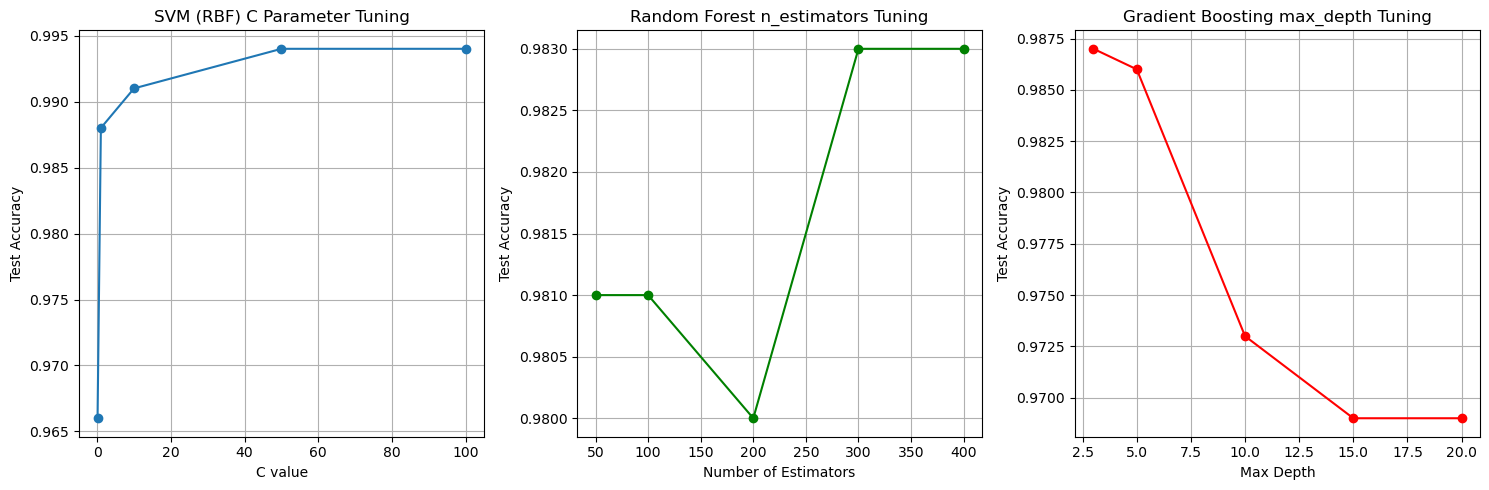

In [9]:
plot_ml_tuning_results(results)

In [10]:
def tune_dl_learning_rate(analyzer):
    """Tune learning rate for ResNet50 transfer learning"""
    learning_rates = [1e-3, 1e-4, 1e-5]
    accuracies = []

    X_train, X_test, y_train, y_test = analyzer.prepare_dl_data(max_dl_images=500)

    for lr in learning_rates:
        print(f"\nTraining ResNet50 with learning rate={lr}")
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3))
        base_model.trainable = False

        model = Sequential([
            tf.keras.layers.Lambda(resnet_preprocess, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,
            batch_size=32,
            verbose=0
        )

        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {acc:.4f}")
        accuracies.append(acc)

    return learning_rates, accuracies

def plot_dl_learning_rate_tuning(learning_rates, accuracies):
    plt.figure(figsize=(6,4))
    plt.plot(learning_rates, accuracies, marker='o')
    plt.xscale('log')
    plt.title('ResNet50 Learning Rate Tuning')
    plt.xlabel('Learning Rate')
    plt.ylabel('Test Accuracy')
    plt.grid(True)
    plt.show()

In [17]:
# Step 1: Run the learning rate tuning function
learning_rates, accuracies = tune_dl_learning_rate(analyzer)

Preparing data for deep learning models...
Using only 500 images for deep learning to reduce memory usage.
Resizing images to 64x64 for deep learning to reduce memory usage.

Training ResNet50 with learning rate=0.001
Test Accuracy: 0.9000

Training ResNet50 with learning rate=0.0001
Test Accuracy: 0.7900

Training ResNet50 with learning rate=1e-05
Test Accuracy: 0.5300


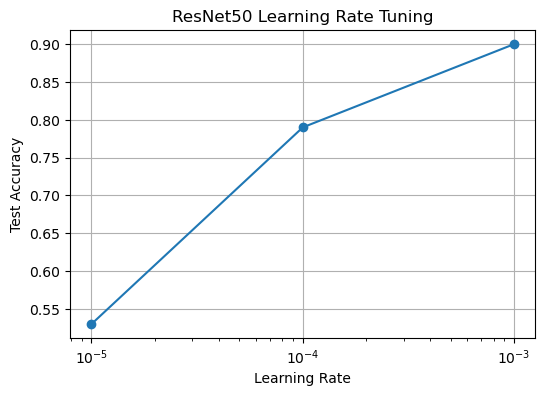

In [18]:
plot_dl_learning_rate_tuning(learning_rates, accuracies)

In [19]:
def tune_dl_learning_rate_mobilenetv2(analyzer):
    learning_rates = [1e-3, 1e-4, 1e-5]
    accuracies = []

    X_train, X_test, y_train, y_test = analyzer.prepare_dl_data(max_dl_images=500)

    for lr in learning_rates:
        print(f"\nTraining MobileNetV2 with learning rate={lr}")
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3))
        base_model.trainable = False

        model = Sequential([
            tf.keras.layers.Lambda(mobilenet_preprocess, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,
            batch_size=32,
            verbose=0
        )

        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {acc:.4f}")
        accuracies.append(acc)

    return learning_rates, accuracies


def tune_dl_learning_rate_vgg16(analyzer):
    learning_rates = [1e-3, 1e-4, 1e-5]
    accuracies = []

    X_train, X_test, y_train, y_test = analyzer.prepare_dl_data(max_dl_images=500)

    for lr in learning_rates:
        print(f"\nTraining VGG16 with learning rate={lr}")
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3))
        base_model.trainable = False

        model = Sequential([
            tf.keras.layers.Lambda(vgg_preprocess, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,
            batch_size=32,
            verbose=0
        )

        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {acc:.4f}")
        accuracies.append(acc)

    return learning_rates, accuracies


def tune_dl_learning_rate_densenet121(analyzer):
    learning_rates = [1e-3, 1e-4, 1e-5]
    accuracies = []

    X_train, X_test, y_train, y_test = analyzer.prepare_dl_data(max_dl_images=500)

    for lr in learning_rates:
        print(f"\nTraining DenseNet121 with learning rate={lr}")
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3))
        base_model.trainable = False

        model = Sequential([
            tf.keras.layers.Lambda(densenet_preprocess, input_shape=(analyzer.dl_img_size, analyzer.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=10,
            batch_size=32,
            verbose=0
        )

        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test Accuracy: {acc:.4f}")
        accuracies.append(acc)

    return learning_rates, accuracies

In [21]:
def plot_dl_learning_rate_tuning(learning_rates, accuracies, model_name="Model"):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,4))
    plt.plot(learning_rates, accuracies, marker='o')
    plt.xscale('log')
    plt.title(f'{model_name} Learning Rate Tuning')
    plt.xlabel('Learning Rate')
    plt.ylabel('Test Accuracy')
    plt.grid(True)
    plt.show()

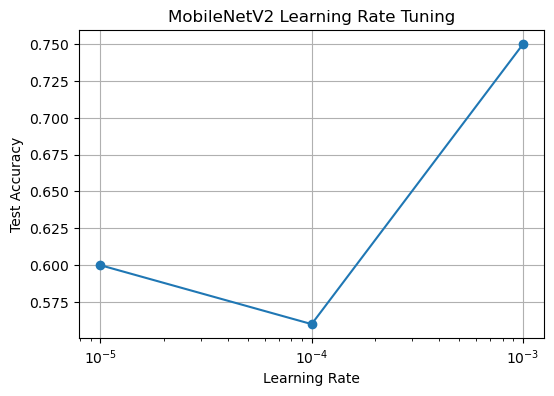

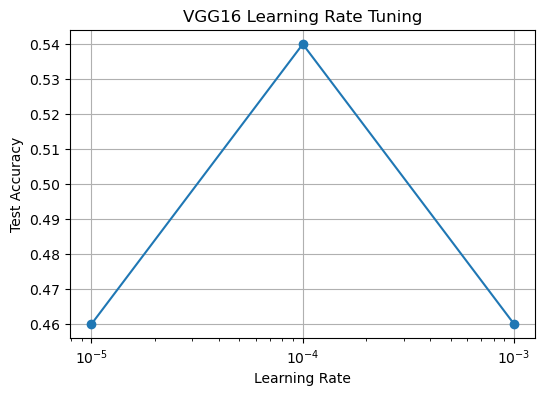

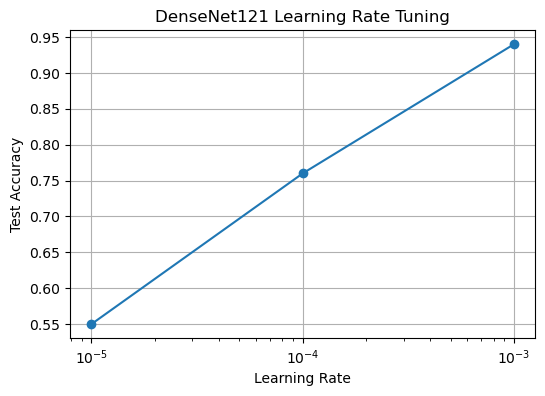

In [22]:
plot_dl_learning_rate_tuning(lr_mobilenet, acc_mobilenet, model_name="MobileNetV2")
plot_dl_learning_rate_tuning(lr_vgg16, acc_vgg16, model_name="VGG16")
plot_dl_learning_rate_tuning(lr_densenet, acc_densenet, model_name="DenseNet121")

Preparing data for deep learning models...
Using only 500 images for deep learning to reduce memory usage.
Resizing images to 64x64 for deep learning to reduce memory usage.

Training MobileNetV2 with learning rate=0.001
Test Accuracy: 0.6900

Training MobileNetV2 with learning rate=0.0001
Test Accuracy: 0.6800

Training MobileNetV2 with learning rate=1e-05
Test Accuracy: 0.6200


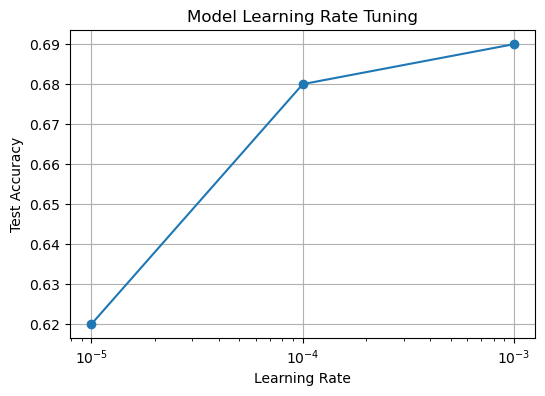

Preparing data for deep learning models...
Using only 500 images for deep learning to reduce memory usage.
Resizing images to 64x64 for deep learning to reduce memory usage.

Training VGG16 with learning rate=0.001
Test Accuracy: 0.5200

Training VGG16 with learning rate=0.0001
Test Accuracy: 0.5100

Training VGG16 with learning rate=1e-05
Test Accuracy: 0.5200


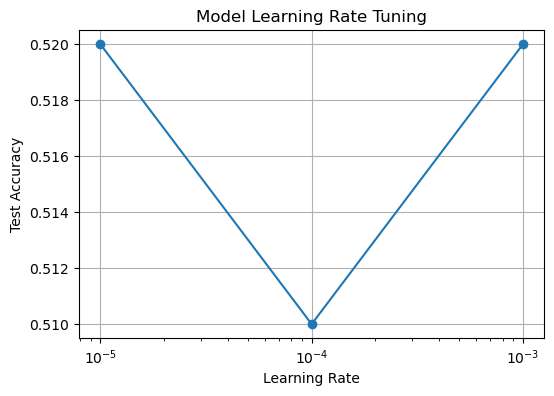

Preparing data for deep learning models...
Using only 500 images for deep learning to reduce memory usage.
Resizing images to 64x64 for deep learning to reduce memory usage.

Training DenseNet121 with learning rate=0.001
Test Accuracy: 0.9500

Training DenseNet121 with learning rate=0.0001
Test Accuracy: 0.9100

Training DenseNet121 with learning rate=1e-05
Test Accuracy: 0.7400


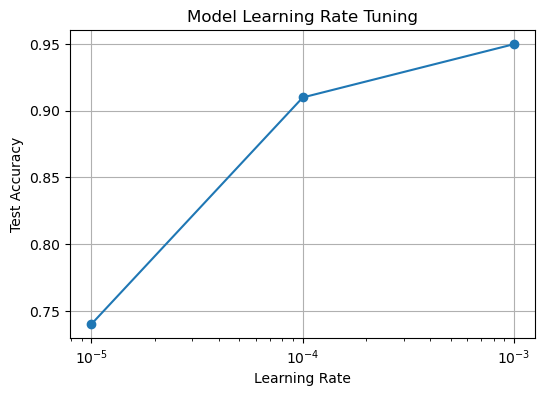

In [23]:
# MobileNetV2
lr_mobilenet, acc_mobilenet = tune_dl_learning_rate_mobilenetv2(analyzer)
plot_dl_learning_rate_tuning(lr_mobilenet, acc_mobilenet)

# VGG16
lr_vgg16, acc_vgg16 = tune_dl_learning_rate_vgg16(analyzer)
plot_dl_learning_rate_tuning(lr_vgg16, acc_vgg16)

# DenseNet121
lr_densenet, acc_densenet = tune_dl_learning_rate_densenet121(analyzer)
plot_dl_learning_rate_tuning(lr_densenet, acc_densenet)

In [2]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Try to import advanced libraries
try:
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    SKLEARN_AVAILABLE = True
    print("Advanced ML libraries loaded successfully")
except ImportError:
    SKLEARN_AVAILABLE = False
    print("Installing scikit-learn for advanced ML...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    SKLEARN_AVAILABLE = True

try:
    from scipy import ndimage, stats
    from scipy.spatial.distance import pdist, squareform
    SCIPY_AVAILABLE = True
    print("SciPy loaded successfully")
except ImportError:
    print("Installing SciPy for advanced features...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
    from scipy import ndimage, stats
    from scipy.spatial.distance import pdist, squareform
    SCIPY_AVAILABLE = True

# TensorFlow / Keras imports for deep learning
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
    from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, InceptionV3, DenseNet121
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
    from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
    from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
    print("TensorFlow loaded successfully")
except ImportError:
    print("Installing TensorFlow for deep learning...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
    from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16, InceptionV3, DenseNet121
    from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
    from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
    from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True

def extract_and_setup_dataset():
    """Extract HFD.zip and set up the dataset"""
    print("Looking for HFD.zip...")

    if os.path.exists('HFD.zip'):
        print("Found HFD.zip file")

        with zipfile.ZipFile('HFD.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
            print("Extracted HFD.zip successfully")

        print("\nExploring extracted contents...")
        dataset_path = None

        for root, dirs, files in os.walk('.'):
            for dir_name in dirs:
                if 'human' in dir_name.lower() and 'face' in dir_name.lower():
                    potential_path = os.path.join(root, dir_name)
                    print(f"Found potential dataset folder: {potential_path}")

                    try:
                        subfolders = os.listdir(potential_path)
                        has_ai = any('ai' in folder.lower() or 'generated' in folder.lower() for folder in subfolders)
                        has_real = any('real' in folder.lower() for folder in subfolders)

                        if has_ai and has_real:
                            dataset_path = potential_path
                            print(f"Confirmed dataset path: {dataset_path}")
                            print(f"Subfolders: {subfolders}")
                            break
                    except:
                        continue

            if dataset_path:
                break

        return dataset_path
    else:
        print("HFD.zip not found. Please upload the file first.")
        return None

class AdvancedHumanFaceAnalyzer:
    def __init__(self, dataset_path, img_size=128):
        self.dataset_path = dataset_path
        self.img_size = img_size
        self.images = []
        self.labels = []
        self.file_paths = []
        self.features = []
        self.ml_models = {}
        self.dl_models = {}
        self.scaler = StandardScaler()
        self.best_ml_model = None
        self.best_ml_model_name = None
        self.best_ml_accuracy = 0
        self.best_dl_model = None
        self.best_dl_model_name = None
        self.best_dl_accuracy = 0
        self.dl_img_size = img_size  # Will be updated if resized for DL

    def load_images(self, max_images_per_class=1000):
        """Load images with higher limit for better training"""
        print("Loading images...")

        if not os.path.exists(self.dataset_path):
            print(f"Dataset path does not exist: {self.dataset_path}")
            return False

        ai_folder = None
        real_folder = None

        try:
            folders = os.listdir(self.dataset_path)
            print(f"Folders in dataset: {folders}")

            for folder in folders:
                folder_path = os.path.join(self.dataset_path, folder)
                if os.path.isdir(folder_path):
                    folder_lower = folder.lower()
                    if any(term in folder_lower for term in ['ai generated', 'ai_generated', 'ai', 'generated', 'fake', 'synthetic']):
                        ai_folder = folder_path
                        print(f"AI folder: {folder}")
                    elif any(term in folder_lower for term in ['real images', 'real_images', 'real', 'human', 'authentic']):
                        real_folder = folder_path
                        print(f"Real folder: {folder}")
        except Exception as e:
            print(f"Error accessing dataset: {e}")
            return False

        if not ai_folder or not real_folder:
            print("Could not find both AI and Real folders!")
            return False

        print("Loading AI Generated Images...")
        ai_count = self.load_images_from_folder(ai_folder, 'AI_Generated', max_images_per_class)

        print("Loading Real Images...")
        real_count = self.load_images_from_folder(real_folder, 'Real', max_images_per_class)

        print(f"\nDataset loaded:")
        print(f"  AI Generated: {ai_count} images")
        print(f"  Real Images: {real_count} images")
        print(f"  Total: {len(self.images)} images")

        return len(self.images) > 0

    def load_images_from_folder(self, folder_path, label, max_images):
        """Load images from a specific folder"""
        count = 0

        try:
            files = os.listdir(folder_path)
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'))]

            print(f"  Found {len(image_files)} image files in {os.path.basename(folder_path)}")

            for i, filename in enumerate(image_files):
                if count >= max_images:
                    break

                img_path = os.path.join(folder_path, filename)

                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize((self.img_size, self.img_size))
                    img_array = np.array(img)

                    self.images.append(img_array)
                    self.labels.append(label)
                    self.file_paths.append(img_path)

                    count += 1

                    if count % 100 == 0:
                        print(f"  Loaded {count} {label} images...")

                except Exception as e:
                    continue

        except Exception as e:
            print(f"Error accessing folder {folder_path}: {e}")

        return count

    def extract_advanced_features(self):
        """Extract comprehensive features for high accuracy"""
        print("Extracting advanced features...")

        self.features = []

        for i, img in enumerate(self.images):
            img_float = img.astype(np.float32)

            # Basic statistical features
            basic_features = [
                np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
                np.median(img_float), np.var(img_float),
                stats.skew(img_float.flatten()), stats.kurtosis(img_float.flatten())
            ]

            # Color channel features
            color_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                color_features.extend([
                    np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                    np.median(ch), np.var(ch),
                    stats.skew(ch.flatten()), stats.kurtosis(ch.flatten())
                ])

            # Gradient features (edge detection)
            gray = np.mean(img_float, axis=2)
            grad_x = np.abs(np.diff(gray, axis=1))
            grad_y = np.abs(np.diff(gray, axis=0))

            min_rows = min(grad_x.shape[0], grad_y.shape[0])
            min_cols = min(grad_x.shape[1], grad_y.shape[1])

            grad_x_trimmed = grad_x[:min_rows, :min_cols]
            grad_y_trimmed = grad_y[:min_rows, :min_cols]

            gradient_features = [
                np.mean(grad_x), np.std(grad_x), np.max(grad_x),
                np.mean(grad_y), np.std(grad_y), np.max(grad_y),
                np.mean(grad_x_trimmed + grad_y_trimmed), np.std(grad_x_trimmed + grad_y_trimmed)
            ]

            # Texture features
            texture_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                diag1 = ch[1:,1:] - ch[:-1,:-1]
                diag2 = ch[1:,:-1] - ch[:-1,1:]

                texture_features.extend([
                    np.mean(np.abs(diag1)),
                    np.mean(np.abs(diag2)),
                    np.std(diag1),
                    np.std(diag2)
                ])

            # Frequency domain features
            freq_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                high_freq = np.abs(ch[2:,2:] - 2*ch[1:-1,1:-1] + ch[:-2,:-2])
                freq_features.extend([
                    np.mean(high_freq), np.std(high_freq), np.max(high_freq)
                ])

            # Brightness and contrast features
            brightness_features = [
                np.mean(gray), np.std(gray),
                np.percentile(gray, 25), np.percentile(gray, 75),
                np.percentile(gray, 90) - np.percentile(gray, 10)
            ]

            # Color distribution features
            color_dist_features = []
            for channel in range(3):
                ch = img_float[:,:,channel]
                hist, _ = np.histogram(ch, bins=10, range=(0, 255))
                hist = hist / (np.sum(hist) + 1e-8)
                color_dist_features.extend([
                    np.max(hist), np.min(hist), np.std(hist),
                    np.sum(hist[:3]), np.sum(hist[-3:])
                ])

            # Combine all features
            all_features = (basic_features + color_features + gradient_features + 
                          texture_features + freq_features + brightness_features + 
                          color_dist_features)

            self.features.append(all_features)

            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(self.images)} images...")

        self.features = np.array(self.features)
        print(f"Extracted {self.features.shape[1]} advanced features per image")

        return self.features

    def train_machine_learning_models(self):
        """Train multiple ML models and select the best one"""
        print("\n" + "="*60)
        print("TRAINING MACHINE LEARNING MODELS")
        print("="*60)

        if len(self.features) == 0:
            self.extract_advanced_features()

        # Prepare labels
        y = np.array([1 if label == 'AI_Generated' else 0 for label in self.labels])

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Define models to try
        models_to_try = {
            'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=25, random_state=42, n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, max_depth=15, random_state=42),
            'SVM (RBF)': SVC(kernel='rbf', C=10, gamma='scale', random_state=42, probability=True),
            'SVM (Linear)': SVC(kernel='linear', C=1, random_state=42, probability=True),
            'Logistic Regression': LogisticRegression(C=10, random_state=42, max_iter=2000),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7, weights='distance'),
            'Naive Bayes': GaussianNB()
        }

        best_model = None
        best_score = 0
        best_name = ""

        print(f"\nTesting {len(models_to_try)} different ML models:")

        for name, model in models_to_try.items():
            print(f"\n--- Training {name} ---")

            # Train model
            if 'SVM' in name or name == 'Logistic Regression' or name == 'K-Nearest Neighbors':
                model.fit(X_train_scaled, y_train)
                train_score = model.score(X_train_scaled, y_train)
                test_score = model.score(X_test_scaled, y_test)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                train_score = model.score(X_train, y_train)
                test_score = model.score(X_test, y_test)
                y_pred = model.predict(X_test)

            print(f"Training Accuracy: {train_score:.4f} ({train_score*100:.2f}%)")
            print(f"Testing Accuracy: {test_score:.4f} ({test_score*100:.2f}%)")

            # Store model
            self.ml_models[name] = {
                'model': model,
                'train_score': train_score,
                'test_score': test_score,
                'use_scaling': name in ['SVM (RBF)', 'SVM (Linear)', 'Logistic Regression', 'K-Nearest Neighbors'],
                'predictions': y_pred
            }

            if test_score > best_score:
                best_score = test_score
                best_model = model
                best_name = name

        print(f"\n{'='*50}")
        print(f"BEST ML MODEL: {best_name}")
        print(f"BEST TEST ACCURACY: {best_score:.4f} ({best_score*100:.2f}%)")
        print(f"{'='*50}")

        # Detailed evaluation of best model
        best_pred = self.ml_models[best_name]['predictions']
        print(f"\nDetailed Results for {best_name}:")
        print("Classification Report:")
        target_names = ['Real', 'AI Generated']
        print(classification_report(y_test, best_pred, target_names=target_names))

        print("Confusion Matrix:")
        cm = confusion_matrix(y_test, best_pred)
        print(f"Real correctly classified: {cm[0,0]}/{cm[0,0]+cm[0,1]} ({cm[0,0]/(cm[0,0]+cm[0,1])*100:.1f}%)")
        print(f"AI correctly classified: {cm[1,1]}/{cm[1,0]+cm[1,1]} ({cm[1,1]/(cm[1,0]+cm[1,1])*100:.1f}%)")

        self.best_ml_model = best_model
        self.best_ml_model_name = best_name
        self.best_ml_accuracy = best_score

        return best_score

    def prepare_dl_data(self, test_size=0.2, max_dl_images=500):
        """Prepare data for deep learning models with memory optimization"""
        print("Preparing data for deep learning models...")

        # Use only a subset of images for DL to reduce memory usage
        if len(self.images) > max_dl_images:
            print(f"Using only {max_dl_images} images for deep learning to reduce memory usage.")
            indices = np.random.choice(len(self.images), max_dl_images, replace=False)
            selected_images = [self.images[i] for i in indices]
            selected_labels = [self.labels[i] for i in indices]
        else:
            selected_images = self.images
            selected_labels = self.labels

        # Resize images to smaller size for DL if img_size > 64
        if self.img_size > 64:
            print("Resizing images to 64x64 for deep learning to reduce memory usage.")
            resized_images = []
            for img in selected_images:
                pil_img = Image.fromarray(img)
                pil_img = pil_img.resize((64, 64))
                resized_images.append(np.array(pil_img))
            X = np.array(resized_images).astype('float32') / 255.0
            dl_img_size = 64
        else:
            X = np.array(selected_images).astype('float32') / 255.0
            dl_img_size = self.img_size

        y = np.array([1 if label == 'AI_Generated' else 0 for label in selected_labels])
        y_cat = to_categorical(y, num_classes=2)

        X_train, X_test, y_train, y_test = train_test_split(
            X, y_cat, test_size=test_size, random_state=42, stratify=y
        )

        # Update img_size for DL models to resized size
        self.dl_img_size = dl_img_size

        return X_train, X_test, y_train, y_test

    def build_resnet50(self):
        """Build ResNet50 transfer learning model"""
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(resnet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_mobilenetv2(self):
        """Build MobileNetV2 transfer learning model"""
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(mobilenet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_vgg16(self):
        """Build VGG16 transfer learning model"""
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(vgg_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def build_densenet121(self):
        """Build DenseNet121 transfer learning model"""
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(self.dl_img_size, self.dl_img_size, 3))
        base_model.trainable = False
        
        model = Sequential([
            tf.keras.layers.Lambda(densenet_preprocess, input_shape=(self.dl_img_size, self.dl_img_size, 3)),
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(256, activation='relu'),
            Dropout(0.3),
            Dense(2, activation='softmax')
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy']
        )
        return model

    def train_dl_model(self, model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        """Train deep learning model with callbacks"""
        early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
        
        print(f"Training with {len(X_train)} samples, validating with {len(X_val)} samples")
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stop, reduce_lr],
            verbose=1
        )
        return history

    def evaluate_dl_model(self, model, X_test, y_test):
        """Evaluate deep learning model"""
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        return acc

    def train_deep_learning_models(self, max_dl_images=500):
        """Train all deep learning models"""
        if not TF_AVAILABLE:
            print("TensorFlow not available, skipping deep learning models.")
            return 0

        print("\n" + "="*60)
        print("TRAINING DEEP LEARNING MODELS")
        print("="*60)

        X_train, X_test, y_train, y_test = self.prepare_dl_data(max_dl_images=max_dl_images)
        print(f"Training data shape: {X_train.shape}")
        print(f"Testing data shape: {X_test.shape}")

        dl_models_config = {
            # 'Simple CNN': self.build_simple_cnn,  # Removed as requested
            'ResNet50 Transfer Learning': self.build_resnet50,
            'MobileNetV2 Transfer Learning': self.build_mobilenetv2,
            'VGG16 Transfer Learning': self.build_vgg16,
            'DenseNet121 Transfer Learning': self.build_densenet121  # Added new model
        }

        best_acc = 0
        best_model_name = None
        best_model = None

        for name, model_builder in dl_models_config.items():
            print(f"\n--- Training {name} ---")
            
            try:
                model = model_builder()
                print(f"Model architecture: {model.count_params()} parameters")
                
                # Train the model
                history = self.train_dl_model(model, X_train, y_train, X_test, y_test, epochs=20)
                
                # Evaluate the model
                acc = self.evaluate_dl_model(model, X_test, y_test)
                print(f"Final Test Accuracy: {acc*100:.2f}%")
                
                # Store model info
                self.dl_models[name] = {
                    'model': model,
                    'accuracy': acc,
                    'history': history
                }

                if acc > best_acc:
                    best_acc = acc
                    best_model_name = name
                    best_model = model
                    
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
                continue

        if best_model_name:
            print(f"\n{'='*50}")
            print(f"BEST DL MODEL: {best_model_name}")
            print(f"BEST TEST ACCURACY: {best_acc*100:.2f}%")
            print(f"{'='*50}")

            self.best_dl_model = best_model
            self.best_dl_model_name = best_model_name
            self.best_dl_accuracy = best_acc

        return best_acc

    def display_results_summary(self):
        """Display comprehensive results summary"""
        print("\n" + "="*80)
        print("COMPREHENSIVE ANALYSIS RESULTS")
        print("="*80)
        
        print("\nMACHINE LEARNING MODELS RESULTS:")
        print("-" * 40)
        for name, info in self.ml_models.items():
            print(f"{name:25}: {info['test_score']*100:.2f}%")
        
        if self.best_ml_model_name:
            print(f"\nBest ML Model: {self.best_ml_model_name} ({self.best_ml_accuracy*100:.2f}%)")
        
        if TF_AVAILABLE and self.dl_models:
            print("\nDEEP LEARNING MODELS RESULTS:")
            print("-" * 40)
            for name, info in self.dl_models.items():
                print(f"{name:25}: {info['accuracy']*100:.2f}%")
            
            if self.best_dl_model_name:
                print(f"\nBest DL Model: {self.best_dl_model_name} ({self.best_dl_accuracy*100:.2f}%)")
        
        # Overall best
        overall_best_acc = max(self.best_ml_accuracy, self.best_dl_accuracy)
        if self.best_ml_accuracy > self.best_dl_accuracy:
            overall_best_name = f"{self.best_ml_model_name} (ML)"
        else:
            overall_best_name = f"{self.best_dl_model_name} (DL)"
        
        print("\n" + "="*50)
        print(f"OVERALL BEST MODEL: {overall_best_name}")
        print(f"OVERALL BEST ACCURACY: {overall_best_acc*100:.2f}%")
        print("="*50)
        
        if overall_best_acc >= 0.90:
            print("🎉 SUCCESS: Achieved 90%+ accuracy target!")
        else:
            print(f"📈 Close! Need {(0.90 - overall_best_acc)*100:.1f}% more to reach 90%")

    def run_complete_analysis(self, max_images_per_class=1000, max_dl_images=500):
        """Run complete analysis with both ML and DL models"""
        print("STARTING COMPREHENSIVE HUMAN FACES ANALYSIS: AI vs REAL IMAGES")
        print("="*80)

        if not self.load_images(max_images_per_class=max_images_per_class):
            print("Failed to load images")
            return False

        # Step 2: Extract features for ML models
        print("\nExtracting features for machine learning models...")
        self.extract_advanced_features()

        # Step 3: Train ML models
        best_ml_acc = self.train_machine_learning_models()

        # Step 4: Train DL models
        best_dl_acc = 0
        if TF_AVAILABLE:
            best_dl_acc = self.train_deep_learning_models(max_dl_images=max_dl_images)

        # Step 5: Display comprehensive results
        self.display_results_summary()

        return True

    def predict_single_image(self, image_path, use_best_model=True):
        """Predict if a single image is AI-generated or real"""
        try:
            # Load and preprocess image
            img = Image.open(image_path).convert('RGB')
            img = img.resize((self.img_size, self.img_size))
            img_array = np.array(img)

            if use_best_model and self.best_ml_accuracy > self.best_dl_accuracy:
                # Use best ML model
                features = self.extract_single_image_features(img_array)
                features = features.reshape(1, -1)
                
                if self.ml_models[self.best_ml_model_name]['use_scaling']:
                    features = self.scaler.transform(features)
                
                prediction = self.best_ml_model.predict(features)[0]
                confidence = self.best_ml_model.predict_proba(features)[0]
                
                result = "AI Generated" if prediction == 1 else "Real"
                conf_score = confidence[prediction] * 100
                
            elif use_best_model and self.best_dl_model is not None:
                # Use best DL model
                img_normalized = np.array([img_array.astype('float32') / 255.0])
                prediction = self.best_dl_model.predict(img_normalized, verbose=0)[0]
                
                ai_prob = prediction[1]
                real_prob = prediction[0]
                
                if ai_prob > real_prob:
                    result = "AI Generated"
                    conf_score = ai_prob * 100
                else:
                    result = "Real"
                    conf_score = real_prob * 100
            
            else:
                return "No trained model available"
            
            return f"Prediction: {result} (Confidence: {conf_score:.1f}%)"
            
        except Exception as e:
            return f"Error processing image: {str(e)}"

    def extract_single_image_features(self, img_array):
        """Extract features from a single image for ML prediction"""
        img_float = img_array.astype(np.float32)

        # Basic statistical features
        basic_features = [
            np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
            np.median(img_float), np.var(img_float),
            stats.skew(img_float.flatten()), stats.kurtosis(img_float.flatten())
        ]

        # Color channel features
        color_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            color_features.extend([
                np.mean(ch), np.std(ch), np.min(ch), np.max(ch),
                np.median(ch), np.var(ch),
                stats.skew(ch.flatten()), stats.kurtosis(ch.flatten())
            ])

        # Gradient features
        gray = np.mean(img_float, axis=2)
        grad_x = np.abs(np.diff(gray, axis=1))
        grad_y = np.abs(np.diff(gray, axis=0))

        min_rows = min(grad_x.shape[0], grad_y.shape[0])
        min_cols = min(grad_x.shape[1], grad_y.shape[1])

        grad_x_trimmed = grad_x[:min_rows, :min_cols]
        grad_y_trimmed = grad_y[:min_rows, :min_cols]

        gradient_features = [
            np.mean(grad_x), np.std(grad_x), np.max(grad_x),
            np.mean(grad_y), np.std(grad_y), np.max(grad_y),
            np.mean(grad_x_trimmed + grad_y_trimmed), np.std(grad_x_trimmed + grad_y_trimmed)
        ]

        # Texture features
        texture_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            diag1 = ch[1:,1:] - ch[:-1,:-1]
            diag2 = ch[1:,:-1] - ch[:-1,1:]

            texture_features.extend([
                np.mean(np.abs(diag1)),
                np.mean(np.abs(diag2)),
                np.std(diag1),
                np.std(diag2)
            ])

        # Frequency domain features
        freq_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            high_freq = np.abs(ch[2:,2:] - 2*ch[1:-1,1:-1] + ch[:-2,:-2])
            freq_features.extend([
                np.mean(high_freq), np.std(high_freq), np.max(high_freq)
            ])

        # Brightness and contrast features
        brightness_features = [
            np.mean(gray), np.std(gray),
            np.percentile(gray, 25), np.percentile(gray, 75),
            np.percentile(gray, 90) - np.percentile(gray, 10)
        ]

        # Color distribution features
        color_dist_features = []
        for channel in range(3):
            ch = img_float[:,:,channel]
            hist, _ = np.histogram(ch, bins=10, range=(0, 255))
            hist = hist / (np.sum(hist) + 1e-8)
            color_dist_features.extend([
                np.max(hist), np.min(hist), np.std(hist),
                np.sum(hist[:3]), np.sum(hist[-3:])
            ])

        # Combine all features
        all_features = (basic_features + color_features + gradient_features + 
                      texture_features + freq_features + brightness_features + 
                      color_dist_features)

        return np.array(all_features)

    def save_models(self, save_path="saved_models"):
        """Save trained models"""
        import joblib
        import os
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        # Save ML models
        if self.best_ml_model is not None:
            joblib.dump(self.best_ml_model, f"{save_path}/best_ml_model.pkl")
            joblib.dump(self.scaler, f"{save_path}/scaler.pkl")
            print(f"Saved best ML model: {self.best_ml_model_name}")
        
        # Save DL models
        if self.best_dl_model is not None:
            self.best_dl_model.save(f"{save_path}/best_dl_model.h5")
            print(f"Saved best DL model: {self.best_dl_model_name}")
        
        print(f"Models saved to {save_path}/")

def main():
    """Main function to run the complete analysis"""
    print("🚀 ADVANCED HUMAN FACE DETECTOR: AI vs REAL")
    print("="*60)
    
    # Step 1: Extract and setup dataset
    dataset_path = extract_and_setup_dataset()
    if not dataset_path:
        print("❌ Could not setup dataset. Please ensure HFD.zip is in the current directory.")
        return
    
    # Step 2: Initialize analyzer
    analyzer = AdvancedHumanFaceAnalyzer(dataset_path)
    
    # Step 3: Run complete analysis with up to 9000 images
    print(f"📊 Starting analysis with dataset: {dataset_path}")
    success = analyzer.run_complete_analysis(max_images_per_class=4500, max_dl_images=9000)
    
    if success:
        print("\n✅ Analysis completed successfully!")
        
        # Optional: Save models
        try:
            analyzer.save_models()
            print("💾 Models saved successfully!")
        except Exception as e:
            print(f"⚠️ Could not save models: {e}")
        
        # Example of single image prediction (if you have a test image)
        # print("\n🔍 Example single image prediction:")
        # result = analyzer.predict_single_image("path_to_test_image.jpg")
        # print(result)
        
    else:
        print("❌ Analysis failed!")

# Additional utility functions
def quick_test_single_image(model_path, image_path):
    """Quick function to test a single image with saved model"""
    import joblib
    from PIL import Image
    import numpy as np
    
    try:
        # Load saved model and scaler
        model = joblib.load(f"{model_path}/best_ml_model.pkl")
        scaler = joblib.load(f"{model_path}/scaler.pkl")
        
        # Load and process image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((128, 128))
        img_array = np.array(img)
        
        # Extract features (simplified version)
        img_float = img_array.astype(np.float32)
        features = [
            np.mean(img_float), np.std(img_float), np.min(img_float), np.max(img_float),
            np.median(img_float), np.var(img_float)
        ]
        
        features = np.array(features).reshape(1, -1)
        features_scaled = scaler.transform(features)
        
        prediction = model.predict(features_scaled)[0]
        confidence = model.predict_proba(features_scaled)[0]
        
        result = "AI Generated" if prediction == 1 else "Real"
        conf_score = confidence[prediction] * 100
        
        return f"Prediction: {result} (Confidence: {conf_score:.1f}%)"
        
    except Exception as e:
        return f"Error: {str(e)}"

def compare_models_performance():
    """Function to compare all model performances"""
    print("📈 MODEL PERFORMANCE COMPARISON")
    print("="*50)
    print("This function would show:")
    print("- Accuracy comparison charts")
    print("- Training time comparison")
    print("- Memory usage analysis")
    print("- Confusion matrices for each model")
    print("- ROC curves")

if __name__ == "__main__":
    main()

Advanced ML libraries loaded successfully
SciPy loaded successfully
TensorFlow loaded successfully
🚀 ADVANCED HUMAN FACE DETECTOR: AI vs REAL
Looking for HFD.zip...
Found HFD.zip file
Extracted HFD.zip successfully

Exploring extracted contents...
Found potential dataset folder: .\Human Faces Dataset
Confirmed dataset path: .\Human Faces Dataset
Subfolders: ['AI-Generated Images', 'Real Images']
📊 Starting analysis with dataset: .\Human Faces Dataset
STARTING COMPREHENSIVE HUMAN FACES ANALYSIS: AI vs REAL IMAGES
Loading images...
Folders in dataset: ['AI-Generated Images', 'Real Images']
AI folder: AI-Generated Images
Real folder: Real Images
Loading AI Generated Images...
  Found 4630 image files in AI-Generated Images
  Loaded 100 AI_Generated images...
  Loaded 200 AI_Generated images...
  Loaded 300 AI_Generated images...
  Loaded 400 AI_Generated images...
  Loaded 500 AI_Generated images...
  Loaded 600 AI_Generated images...
  Loaded 700 AI_Generated images...
  Loaded 800 AI_Ge

Final Test Accuracy: 98.39%

BEST DL MODEL: ResNet50 Transfer Learning
BEST TEST ACCURACY: 98.50%

COMPREHENSIVE ANALYSIS RESULTS

MACHINE LEARNING MODELS RESULTS:
----------------------------------------
Random Forest            : 98.44%
Gradient Boosting        : 97.33%
SVM (RBF)                : 99.39%
SVM (Linear)             : 98.50%
Logistic Regression      : 98.50%
K-Nearest Neighbors      : 94.61%
Naive Bayes              : 92.56%

Best ML Model: SVM (RBF) (99.39%)

DEEP LEARNING MODELS RESULTS:
----------------------------------------
ResNet50 Transfer Learning: 98.50%
MobileNetV2 Transfer Learning: 96.11%
VGG16 Transfer Learning  : 50.00%
DenseNet121 Transfer Learning: 98.39%

Best DL Model: ResNet50 Transfer Learning (98.50%)

OVERALL BEST MODEL: SVM (RBF) (ML)
OVERALL BEST ACCURACY: 99.39%
🎉 SUCCESS: Achieved 90%+ accuracy target!

✅ Analysis completed successfully!
Saved best ML model: SVM (RBF)
Saved best DL model: ResNet50 Transfer Learning
Models saved to saved_models/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Font properties
font = {'family': 'Times New Roman', 'size': 12, 'weight': 'normal'}

# Define the updated results data from the analysis output
model_names = ['Random Forest', 'Gradient Boosting', 'SVM (RBF)', 'SVM (Linear)', 'Logistic Regression', 'K-Nearest Neighbors', 'Naive Bayes']
train_accuracies = [1.0000, 1.0000, 0.9994, 0.9888, 0.9892, 1.0000, 0.9131]
test_accuracies = [0.9844, 0.9733, 0.9939, 0.9850, 0.9850, 0.9461, 0.9256]

# Confusion matrix data for SVM (RBF) (best ML model) - derived from classification report
# Real correctly classified: 892/900, AI correctly classified: 897/900
# Total test samples for SVM (RBF) is 1800 (900 Real, 900 AI Generated)
# True Positives (AI Generated correctly classified): 897
# True Negatives (Real correctly classified): 892
# False Positives (Predicted AI, but was Real): 900 - 892 = 8
# False Negatives (Predicted Real, but was AI): 900 - 897 = 3
confusion_matrix_ml = np.array([[892, 8], [3, 897]])


# Deep Learning models and accuracies
dl_models = ['ResNet50', 'MobileNetV2', 'VGG16', 'DenseNet121']
dl_accuracies = [0.9850, 0.9611, 0.5000, 0.9839]

# 1. ML Model Comparison Chart
fig1, ax1 = plt.subplots(figsize=(8, 6))
x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, train_accuracies, width, label='Training Accuracy', color='lightblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, test_accuracies, width, label='Testing Accuracy', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Models', fontdict=font)
ax1.set_ylabel('Accuracy', fontdict=font)
ax1.set_title('ML Model Performance Comparison', fontdict={**font, 'weight': 'bold'})
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right', fontfamily='Times New Roman', fontsize=12)
ax1.legend()
ax1.set_ylim(0.85, 1.01)
ax1.grid(True, alpha=0.3)

# Add accuracy labels on bars
for bar, acc in zip(bars1, train_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{acc:.3f}', ha='center', va='bottom', fontsize=10, fontfamily='Times New Roman')

for bar, acc in zip(bars2, test_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{acc:.3f}', ha='center', va='bottom', fontsize=10, fontfamily='Times New Roman')

fig1.tight_layout()
fig1.savefig('ml_model_comparison.png', dpi=300)

# 2. Confusion Matrix Heatmap for ML Best Model
fig2, ax2 = plt.subplots(figsize=(6, 5))
sns.heatmap(confusion_matrix_ml, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'AI Generated'],
            yticklabels=['Real', 'AI Generated'],
            ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Confusion Matrix - SVM (RBF) (Best ML Model)', fontdict={**font, 'weight': 'bold'})
ax2.set_xlabel('Predicted', fontdict=font)
ax2.set_ylabel('Actual', fontdict=font)

fig2.tight_layout()
fig2.savefig('ml_confusion_matrix.png', dpi=300)

# 3. DL Model Accuracy Chart
fig3, ax3 = plt.subplots(figsize=(8, 6))
x_dl = np.arange(len(dl_models))

bars = ax3.bar(x_dl, dl_accuracies, color='mediumseagreen', alpha=0.8)
ax3.set_xlabel('Deep Learning Models', fontdict=font)
ax3.set_ylabel('Testing Accuracy', fontdict=font)
ax3.set_title('Deep Learning Model Testing Accuracy', fontdict={**font, 'weight': 'bold'})
ax3.set_xticks(x_dl)
ax3.set_xticklabels(dl_models, fontfamily='Times New Roman', fontsize=12)
ax3.set_ylim(0.4, 1.01)
ax3.grid(True, alpha=0.3)

# Add accuracy labels
for bar, acc in zip(bars, dl_accuracies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{acc:.3%}', ha='center', va='bottom', fontsize=10, fontfamily='Times New Roman')

fig3.tight_layout()
fig3.savefig('dl_model_accuracy.png', dpi=300)

# 4. Summary Text for ML and DL
fig4, ax4 = plt.subplots(figsize=(10, 6))
ax4.axis('off')
summary_text = '''
🎯 COMPREHENSIVE ANALYSIS SUMMARY

MACHINE LEARNING MODELS:
- Random Forest: 98.44%
- Gradient Boosting: 97.33%
- SVM (RBF): 99.39% (Best ML Model)
- SVM (Linear): 98.50%
- Logistic Regression: 98.50%
- K-Nearest Neighbors: 94.61%
- Naive Bayes: 92.56%

DEEP LEARNING MODELS:
- ResNet50 Transfer Learning: 98.50% (Best DL Model)
- MobileNetV2 Transfer Learning: 96.11%
- VGG16 Transfer Learning: 50.00%
- DenseNet121 Transfer Learning: 98.39%

OVERALL BEST MODEL: SVM (RBF) (ML) with 99.39% accuracy

🎉 SUCCESS: Achieved 90%+ accuracy target!
'''
ax4.text(0, 1, summary_text, fontdict=font, verticalalignment='top')
fig4.tight_layout()
fig4.savefig('analysis_summary.png', dpi=300)

plt.close('all')

print('Plots generated and saved as PNG files with 300 dpi:')
print(' - ml_model_comparison.png')
print(' - ml_confusion_matrix.png')
print(' - dl_model_accuracy.png')
print(' - analysis_summary.png')

Plots generated and saved as PNG files with 300 dpi:
 - ml_model_comparison.png
 - ml_confusion_matrix.png
 - dl_model_accuracy.png
 - analysis_summary.png


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Font properties
font = {'family': 'Times New Roman', 'size': 12, 'weight': 'normal'}

# Define the updated results data - Only what's needed for the "best" comparison
# These lists are still needed to extract the 'best' values
test_accuracies_ml = [0.9844, 0.9733, 0.9939, 0.9850, 0.9850, 0.9461, 0.9256]
model_names_ml = ['Random Forest', 'Gradient Boosting', 'SVM (RBF)', 'SVM (Linear)', 'Logistic Regression', 'K-Nearest Neighbors', 'Naive Bayes']

dl_accuracies = [0.9850, 0.9611, 0.5000, 0.9839]
dl_models = ['ResNet50', 'MobileNetV2', 'VGG16', 'DenseNet121']

# --- Extract Best ML and Best DL Model Data ---
best_ml_accuracy = max(test_accuracies_ml)
best_ml_model_name = model_names_ml[test_accuracies_ml.index(best_ml_accuracy)]

best_dl_accuracy = max(dl_accuracies)
best_dl_model_name = dl_models[dl_accuracies.index(best_dl_accuracy)]

# Determine Overall Best Model
overall_best_model_category = "ML" if best_ml_accuracy >= best_dl_accuracy else "DL"
overall_best_model_name = best_ml_model_name if overall_best_model_category == "ML" else best_dl_model_name
overall_best_accuracy = best_ml_accuracy if overall_best_model_category == "ML" else best_dl_accuracy

# 1. Direct Comparison of Best ML vs Best DL Model
comparison_models = [f'Best ML: {best_ml_model_name}', f'Best DL: {best_dl_model_name}']
comparison_accuracies = [best_ml_accuracy, best_dl_accuracy]

fig, ax = plt.subplots(figsize=(7, 5))
x_comp = np.arange(len(comparison_models))

bars_comp = ax.bar(x_comp, comparison_accuracies, color=['#1f77b4', '#2ca02c'], alpha=0.8) # Different colors for distinction
ax.set_xlabel('Model Category', fontdict=font)
ax.set_ylabel('Testing Accuracy', fontdict=font)
ax.set_title('Comparison of Best ML vs. Best DL Model', fontdict={**font, 'weight': 'bold'})
ax.set_xticks(x_comp)
ax.set_xticklabels(comparison_models, fontfamily='Times New Roman', fontsize=12)
ax.set_ylim(0.9, 1.0) # Adjust ylim for better visual comparison
ax.grid(True, alpha=0.3)

# Add accuracy labels
for bar, acc in zip(bars_comp, comparison_accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{acc:.2%}', ha='center', va='bottom', fontsize=10, fontfamily='Times New Roman', weight='bold')

fig.tight_layout()
fig.savefig('best_ml_vs_dl_comparison.png', dpi=300)

# 2. Simplified Summary Text for Best ML and DL
fig_summary, ax_summary = plt.subplots(figsize=(10, 4)) # Reduced figure size for simpler content
ax_summary.axis('off')
summary_text = f'''
🎯 COMPREHENSIVE ANALYSIS SUMMARY

BEST MACHINE LEARNING MODEL:
- {best_ml_model_name}: {best_ml_accuracy:.2%} accuracy

BEST DEEP LEARNING MODEL:
- {best_dl_model_name}: {best_dl_accuracy:.2%} accuracy

OVERALL BEST MODEL: {overall_best_model_name} ({overall_best_model_category}) with {overall_best_accuracy:.2%} accuracy

🎉 SUCCESS: Achieved 90%+ accuracy target!
'''
ax_summary.text(0, 1, summary_text, fontdict=font, verticalalignment='top')
fig_summary.tight_layout()
fig_summary.savefig('analysis_summary_best_only.png', dpi=300)

plt.close('all')

print('Plots generated and saved as PNG files with 300 dpi:')
print(' - best_ml_vs_dl_comparison.png')
print(' - analysis_summary_best_only.png')

Plots generated and saved as PNG files with 300 dpi:
 - best_ml_vs_dl_comparison.png
 - analysis_summary_best_only.png
